cooperativity effect 
add copperativity effects 
75 coverage 
only pool data as significant 
get abs of delta with cooperative direction

## A, P- and E-site analysis at tRNA level

###### Point of action
1. Cooperativity effect calculated for E and P-site effect on A-site
2. 7 ribo-seq data used for thsis analysis
3. Normalised ribsome density calculated for each gene
4. Only 75% coverage gene selected for analysis
5. Statistically significance calculate for each triplet at E-, P- and A-site by permutation test
6. Speed define by delta1
7. Cooperativity effect calculated through delta1, delta2, and delta3
8. Corrected p-value calculated for each triplet by Benjamini Hochberg correction method to control false discovery
10. The robustness of each triplet defines by the two filter criteria. For each triplet, All seven dataset delta1 directions should be in the same direction. Any four datasets should show the same cooperativity effect.
11. analysis of calculated data
12. The combined average effect of a molecular factor on translation elongation rate at the A, P and E-site

# This code has 2 step. 
### Step 1: In First step use raw Asite profile file and generate matrix with A-SITE P-SITE and E-SITE with normalised ribosome density after that calculated the p-value with permuatation test for ever triplets. 
### Step 2: After calculating permutataion test for every triplets for all datasets. In this step merge all dataset and find out robust triplets

# STEP 1

In [1]:
path= '/gpfs/group/epo2/default/nks5512/find_cooperativity_and_no_cooperativity/A_P_Site_matrix_tRNA_level_find_cooperativity_and_no_cooperativity_with_75%_coverage_test/'

dataset = ['Jan','Williams','Young','Weinberg','Nissley1','Nissley2','Pool']

#Intronic gene list
Intronic_gene_list = 'data/intronic_genes.p'

#Overlap gene list
Overlap_gene_list = 'data/overlap_genes.p'

# convert gene nucleotide to codon for every gene
codon_type_dic = 'data/codon_type_dict.p'


# 358 gene list to see robustness in data, This 358 gene data will be use to generate final amino acid metrix and tRNA matrix
Genelist_Williams_data = 'data/Genelist_Williams_data.tab'

# Threshold value for data (eg. Threshold value 4 for 6 data)
threshold_value = 4

#gene coverage thrushold
coverage_value = 75

print('\n Done')


 Done


In [2]:
from __future__ import division
import numpy as np
import math
import os
import pickle
print('Imported numpy, math, os and cPickle')
from optparse import OptionParser
print('Imported optionparser, plotter and misc')
import matplotlib.backends.backend_pdf as pdf
from scipy import stats
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.table import Table
import sys
import statsmodels.sandbox.stats.multicomp as mc
import operator as op
from matplotlib.ticker import FormatStrFormatter
from time import localtime, strftime
import itertools
from matplotlib import rcParams
import shutil
import matplotlib as mpl
mpl.rc('figure', max_open_warning = 0)
import statistics
import math
import random
import timeit
import multiprocessing
from multiprocessing import Pool
import subprocess


CODON_TYPES = ['UUU', 'UUC', 'UUA', 'UUG', 'CUU', 'CUC', 'CUA', 'CUG', 'AUU', 'AUC', 'AUA', 'AUG', 'GUU', 'GUC', 'GUA',
               'GUG', 'UCU', 'UCC', 'UCA', 'UCG', 'CCU', 'CCC', 'CCA', 'CCG', 'ACU', 'ACC', 'ACA', 'ACG', 'GCU', 'GCC',
               'GCA', 'GCG', 'UAU', 'UAC', 'CAU', 'CAC', 'CAA', 'CAG', 'AAU', 'AAC', 'AAA', 'AAG', 'GAU', 'GAC', 'GAA',
               'GAG', 'UGU', 'UGC', 'UGG', 'CGU', 'CGC', 'CGA', 'CGG', 'AGU', 'AGC', 'AGA', 'AGG', 'GGU', 'GGC', 'GGA',
               'GGG', 'UAA', 'UAG', 'UGA']

genetic_code = {'UUU': 'F', 'UCU': 'S', 'UAU': 'Y', 'UGU': 'C', 'UUC': 'F', 'UCC': 'S', 'UAC': 'Y', 'UGC': 'C',
                'UUA': 'L', 'UCA': 'S', 'UAA': '*', 'UGA': '*', 'UUG': 'L', 'UCG': 'S', 'UAG': '*', 'UGG': 'W',
                'CUU': 'L', 'CCU': 'P', 'CAU': 'H', 'CGU': 'R', 'CUC': 'L', 'CCC': 'P', 'CAC': 'H', 'CGC': 'R',
                'CUA': 'L', 'CCA': 'P', 'CAA': 'Q', 'CGA': 'R', 'CUG': 'L', 'CCG': 'P', 'CAG': 'Q', 'CGG': 'R',
                'AUU': 'I', 'ACU': 'T', 'AAU': 'N', 'AGU': 'S', 'AUC': 'I', 'ACC': 'T', 'AAC': 'N', 'AGC': 'S',
                'AUA': 'I', 'ACA': 'T', 'AAA': 'K', 'AGA': 'R', 'AUG': 'M', 'ACG': 'T', 'AAG': 'K', 'AGG': 'R',
                'GUU': 'V', 'GCU': 'A', 'GAU': 'D', 'GGU': 'G', 'GUC': 'V', 'GCC': 'A', 'GAC': 'D', 'GGC': 'G',
                'GUA': 'V', 'GCA': 'A', 'GAA': 'E', 'GGA': 'G', 'GUG': 'V', 'GCG': 'A', 'GAG': 'E', 'GGG': 'G'}

# In the following dict, synonymous codons for each amino acid are grouped in list such that they are decoded by similar tRNA.
# For example, in amino acid 'A', GCU and GCC codons are decoded by one type of tRNA while GCA and GCG are decoded by another kind of tRNA
synonymous = {'A': [['GCU', 'GCC'], ['GCA', 'GCG']],
              'C': [['UGU', 'UGC']],
              'D': [['GAU', 'GAC']],
              'E': [['GAA'], ['GAG']],
              'F': [['UUU', 'UUC']],
              'G': [['GGU', 'GGC'], ['GGA'], ['GGG']],
              'H': [['CAU', 'CAC']],
              'I': [['AUU', 'AUC'], ['AUA']],
              'K': [['AAG'], ['AAA']],
              'L': [['UUG'], ['UUA'], ['CUC', 'CUU'], ['CUA', 'CUG']],
              'M': [['AUG']],
              'N': [['AAU', 'AAC']],
              'P': [['CCA', 'CCG'], ['CCU', 'CCC']],
              'Q': [['CAA'], ['CAG']],
              'R': [['AGA'], ['CGU', 'CGC'], ['CGG', 'CGA'], ['AGG']],
              'S': [['UCU', 'UCC'], ['AGU', 'AGC'], ['UCA'], ['UCG']],
              'T': [['ACU', 'ACC'], ['ACA'], ['ACG']],
              'V': [['GUU', 'GUC'], ['GUG'], ['GUA']],
              'W': [['UGG']],
              'Y': [['UAU', 'UAC']],
              '*': [['UAA', 'UAG', 'UGA']]
              }

properties = {'A': 'NON-POLAR',
              'C': 'NON-POLAR',
              'D': 'Negative',
              'E': 'Negative',
              'F': 'NON-POLAR',
              'G': 'NON-POLAR',
              'H': 'Positive',
              'I': 'NON-POLAR',
              'K': 'Positive',
              'L': 'NON-POLAR',
              'M': 'NON-POLAR',
              'N': 'POLAR',
              'P': 'NON-POLAR',
              'Q': 'POLAR',
              'R': 'Positive',
              'S': 'POLAR',
              'T': 'POLAR',
              'V': 'NON-POLAR',
              'W': 'NON-POLAR',
              'Y': 'POLAR',
              }

hydropathy = {'A': '1.8',
              'C': '2.5',
              'D': '-3.5',
              'E': '-3.5',
              'F': '2.8',
              'G': '-0.4',
              'H': '-3.2',
              'I': '4.5',
              'K': '-3.9',
              'L': '3.8',
              'M': '1.9',
              'N': '-3.5',
              'P': '-1.6',
              'Q': '-3.5',
              'R': '-4.5',
              'S': '-0.8',
              'T': '-0.7',
              'V': '4.2',
              'W': '-0.9',
              'Y': '-1.3',
              }

AMINO_ACIDS = ['A', 'R', 'D', 'N', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V', '*']

tRNA_list = ['A-t1', 'A-t2', 'R-t1', 'R-t2', 'R-t3', 'R-t4', 'D-t1', 'N-t1', 'C-t1', 'E-t1', 'E-t2', 'Q-t1', 'Q-t2', 'G-t1', 'G-t2', 'G-t3', 'H-t1', 'I-t1', 'I-t2', 'L-t1', 'L-t2', 'L-t3', 'L-t4', 'K-t1', 'K-t2', 'M-t1', 'F-t1', 'P-t1', 'P-t2', 'S-t1', 'S-t2', 'S-t3', 'S-t4', 'T-t1', 'T-t2', 'T-t3', 'W-t1', 'Y-t1', 'V-t1', 'V-t2', 'V-t3', '*-t1']

base_pairing = {'A': {'Wobble': ['GCC', 'GCG'], 'Watson-Crick': ['GCA', 'GCU']}, 'R': {'Wobble': ['CGA', 'CGC'], 'Watson-Crick': ['AGA', 'AGG', 'CGG', 'CGU']},
                'D': {'Wobble': ['GAU'], 'Watson-Crick': ['GAC']},
                'N': {'Wobble': ['AAU'], 'Watson-Crick': ['AAC']}, 'C': {'Wobble': ['UGU'], 'Watson-Crick': ['UGC']}, 'E': {'Wobble': [], 'Watson-Crick': ['GAA', 'GAG']},
                'Q': {'Wobble': [], 'Watson-Crick': ['CAA', 'CAG']}, 'G': {'Wobble': ['GGU'], 'Watson-Crick': ['GGA', 'GGC', 'GGG']},
                'H': {'Wobble': ['CAU'], 'Watson-Crick': ['CAC']},
                'I': {'Wobble': ['AUC'], 'Watson-Crick': ['AUA', 'AUU']}, 'L': {'Wobble': ['CUG', 'CUU'], 'Watson-Crick': ['CUA', 'CUC', 'UUA', 'UUG']},
                'K': {'Wobble': [], 'Watson-Crick': ['AAA', 'AAG']},
                'M': {'Wobble': [], 'Watson-Crick': ['AUG']}, 'F': {'Wobble': ['UUU'], 'Watson-Crick': ['UUC']}, 'P': {'Wobble': ['CCC', 'CCG'], 'Watson-Crick': ['CCA', 'CCU']},
                'S': {'Wobble': ['UCC', 'AGU'], 'Watson-Crick': ['UCA', 'UCG', 'UCU', 'AGC']}, 'T': {'Wobble': ['ACC'], 'Watson-Crick': ['ACA', 'ACU', 'ACG']},
                'W': {'Wobble': [], 'Watson-Crick': ['UGG']}, 'Y': {'Wobble': ['UAU'], 'Watson-Crick': ['UAC']}, 'V': {'Wobble': ['GUC'], 'Watson-Crick': ['GUA', 'GUG', 'GUU']},
                '*': {'Wobble': [], 'Watson-Crick': ['UAA', 'UAG', 'UGA']}}

# Optimal codons selected based on their corresponding tRNA abundance (measured by RNA-Seq in Weinberg et al). Wobble only pairs are measured by 0.64*cognate tRNA concentration.
# Corrected mistake for G. Earlier it was 'G': {'Non-optimal': ['GGC', 'GGG'], 'Optimal': ['GGA', 'GGU']},
optimal_codon_usage = {'A': {'Non-optimal': ['GCC', 'GCG'], 'Optimal': ['GCA', 'GCU']}, 'C': {'Non-optimal': ['UGU'], 'Optimal': ['UGC']}, 'D': {'Non-optimal': ['GAU'], 'Optimal': ['GAC']},
                       'E': {'Non-optimal': ['GAG'], 'Optimal': ['GAA']}, 'F': {'Non-optimal': ['UUU'], 'Optimal': ['UUC']}, 'G': {'Non-optimal': ['GGA', 'GGG'], 'Optimal': ['GGC', 'GGU']},
                       'H': {'Non-optimal': ['CAU'], 'Optimal': ['CAC']}, 'I': {'Non-optimal': ['AUA'], 'Optimal': ['AUC', 'AUU']}, 'K': {'Non-optimal': ['AAA'], 'Optimal': ['AAG']},
                       'L': {'Non-optimal': ['CUA', 'CUC', 'CUG', 'CUU'], 'Optimal': ['UUA', 'UUG']}, 'M': {'Non-optimal': [], 'Optimal': ['AUG']}, 'N': {'Non-optimal': ['AAU'], 'Optimal': ['AAC']},
                       'P': {'Non-optimal': ['CCC', 'CCU'], 'Optimal': ['CCA', 'CCG']}, 'Q': {'Non-optimal': ['CAG'], 'Optimal': ['CAA']},
                       'R': {'Non-optimal': ['AGG', 'CGG', 'CGA', 'CGC'], 'Optimal': ['AGA', 'CGU']}, 'S': {'Non-optimal': ['UCA', 'UCG', 'AGU', 'AGC'], 'Optimal': ['UCC', 'UCU']},
                       'T': {'Non-optimal': ['ACA', 'ACG'], 'Optimal': ['ACC', 'ACU']}, 'V': {'Non-optimal': ['GUA', 'GUG'], 'Optimal': ['GUC', 'GUU']}, 'W': {'Non-optimal': [], 'Optimal': ['UGG']},
                       'Y': {'Non-optimal': ['UAU'], 'Optimal': ['UAC']}}

# Most optimal codon for every amino acid
most_optimal_codon = {'A': 'GCU', 'C': 'UGC', 'D': 'GAC', 'E': 'GAA', 'F': 'UUC', 'G': 'GGC', 'H': 'CAC', 'I': 'AUU', 'K': 'AAG', 'L': 'UUG', 'M': 'AUG', 'N': 'AAC', 'P': 'CCA', 'Q': 'CAA', 'R': 'AGA',
                      'S': 'UCU', 'T': 'ACU', 'V': 'GUU', 'W': 'UGG', 'Y': 'UAC', '*': 'UAA'}

# Optimal and non-optimal codons based on Penchman, Frydman, tAI cutoff of 0.47 as well as used for codon optimality in Jeff Coller's paper.
optimal_dict = {'Optimal': ['GCU', 'GCC', 'GAC', 'GAA', 'UUC', 'GGC', 'AUU', 'AUC', 'AAG', 'UUG', 'AUG', 'AAC', 'CCA', 'CAA', 'AGA', 'UCU', 'UCC', 'ACU', 'ACC', 'GUU', 'GUC', 'UAC'],
                'Non-optimal': ['GCA', 'GCG', 'UGC', 'UGU', 'GAU', 'GAG', 'UUU', 'GGU', 'GGA', 'GGG', 'CAC', 'CAU', 'AUA', 'AAA', 'UUA', 'CUA', 'CUC', 'CUG', 'CUU', 'AAU', 'CCG', 'CCU', 'CCC',
                                'CAG', 'CGU', 'AGG', 'CGC', 'CGG', 'CGA', 'UCA', 'AGC', 'UCG', 'AGU', 'ACA', 'ACG', 'GUG', 'GUA', 'UGG', 'UAU']}

CHROMOSOMES = ['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI', 'chrVII', 'chrVIII', 'chrIX', 'chrX', 'chrXI', 'chrXII', 'chrXIII', 'chrXIV', 'chrXV', 'chrXVI', 'chrM']

print ('\nDone')



Imported numpy, math, os and cPickle
Imported optionparser, plotter and misc

Done


In [12]:
# Parse transcriptome file to get a dictionary of codon types for genes.
def parse_sequence(transcript_file, out_loc='/gpfs/group/null/default/nxa176/reference/sacCer3/Reference_files/'):
    codon_type_dict = {}
    with open(transcript_file) as f:
        for lines in f:
            fields = lines.strip().split('\t')
            gene = fields[0]
            if gene.startswith('Q'):
                continue
            start_index = int(fields[1])
            length = int(fields[2])
            cds = list(fields[3])[abs(start_index):abs(start_index) + length]
            # Since we are looking at mRNA, convert any 'T' to 'U'
            codon_list = ['U' if x == 'T' else x for x in cds]
            codon_type_dict[gene] = []
            for x in range(0, len(codon_list), 3):
                codon_type_dict[gene].append(''.join(codon_list[x:x + 3]))

            # Sanitary checks for start and stop codons
            try:
                if codon_type_dict[gene][0] != "AUG":
                    print (gene + " does not have a AUG start codon and the start codon is " + codon_type_dict[gene][0])
            except KeyError:
                print ('KeyError in finding the start codon for gene ', gene, codon_type_dict[gene])
            if codon_type_dict[gene][-1] not in ["UAA", "UAG", "UGA"]:
                print (gene + " does not have UAA/UAG/UGA stop codon and stop codon is " + codon_type_dict[gene][-1])

    pickle.dump(codon_type_dict, open(out_loc + 'codon_type_dict.p', 'wb'))

    return codon_type_dict




# Get the dict containing the codon types of each codon in genes.
    if organism == 'yeast':
        if not os.path.isfile("C:/Users/Nishant_admin/Desktop/ribosome_profiling_test/e-site_project_published_samples/reference_sacCer3/codon_type_dict.p"):
            dict_cdn_types = parse_sequence('C:/Users/Nishant_admin/Desktop/ribosome_profiling_test/e-site_project_published_samples/reference_sacCer3/Transcript_sequence.tab')
        else:
            dict_cdn_types = pickle.load(open('C:/Users/Nishant_admin/Desktop/ribosome_profiling_test/e-site_project_published_samples/reference_sacCer3/codon_type_dict.p', 'rb'))
    elif organism == 'ecoli':
        if not os.path.isfile("/gpfs/group/null/default/nxa176/Asite_project/Code_testing/data_files/ecoli/codon_type_dict.p"):
            dict_cdn_types = parse_sequence('/gpfs/group/null/default/nxa176/Asite_project/Code_testing/data_files/ecoli/ecoli_transcript_sequence.tab',
                                            out_loc='/gpfs/group/null/default/nxa176/Asite_project/Code_testing/data_files/ecoli/')
            print ('Dumped the codon type dict into a pickle')
        else:
            dict_cdn_types = pickle.load(open('/gpfs/group/null/default/nxa176/Asite_project/Code_testing/data_files/ecoli/codon_type_dict.p', 'rb'))
            print ('Parsed codon types from /gpfs/group/null/default/nxa176/Asite_project/Code_testing/data_files/ecoli/codon_type_dict.p')
    else:
        print ('Organism not identified for getting codon types. Current options are only 1) yeast 2)ecoli ')
        print ('Exiting...')
        sys.exit()


        
class StrToBytes:
    def __init__(self, fileobj):
        self.fileobj = fileobj
    def read(self, size):
        return self.fileobj.read(size).encode()
    def readline(self, size=-1):
        return self.fileobj.readline(size).encode()
        
# Parses A-site file for reads per nucleotide.
# Converts reads per nucleotide to reads per codon.
# Filters genes according to the criteria specified in options: genes which have at least 3 reads per codon or/and do not overlap with any other genes or/and do not have introns
def gene_codon_filter_1(asite_file, mul_map_file, mul_map_threshold=1, filter_threshold=0.1, read_threshold=1, strict=True, window=False, relaxed=False):
    # Total reads mapped to a gene
    unique_mapped_reads = {}
    # Total multiple mapped reads mapped to a gene
    mul_mapped_reads = {}
    # Genes with multiple mapped reads to be filtered out from analysis. Default threshold of 1%. Genes with more than 1% multiple mapped reads will be removed.
    mul_map_genes = []

    path1 = path+"A_site_profile_file/gene_codon_filter/"

    try:
        os.makedirs(path1)
    except OSError:
        print("Creation of the directory %s failed")
    else:
        print("Successfully created the directory %s ")
    asite_name = asite_file.split('_')
    file_name = asite_name[-2] + '_' + asite_name[-1]
    file_name = file_name.split('.')
    file_name = file_name[0]
    print(Overlap_gene_list)
    overlap_genes = pickle.load(StrToBytes(open(path+Overlap_gene_list)))
    intronic_genes = pickle.load(StrToBytes(open(path+Intronic_gene_list)))

    stats_file = open(path1 + 'Summary_stats_' + file_name + '.tab', 'w')

    total_read_count = 0
    dict_len = {}
    codon_dict = {}
    # Parse the A-site file to get the reads for each position of each gene
    # We get the reads info in dict_gene_count and the nucleotide info in nuc_dict
    with open(asite_file) as file_asite_table:
        for lines in file_asite_table:
            line_list = lines.strip().split('\t')
            gene = line_list[0]
            gene_length = int(line_list[1])
            count_list = list(map(int, line_list[2].split(',')))
            list_len = len(count_list)
            # Quality check
            if len(count_list) % 3 != 0:
                print(
                    'QUALITY CHECK NOT MET: Gene ' + gene + ' have a length not a multiple of 3. The length is ' + str(
                        len(count_list)))
            if gene.startswith('Q'):
                continue
            codon_dict[gene] = []
            # Convert the reads per nucleotide to reads per codon
            for i in range(0, list_len, 3):
                codon_dict[gene].append(sum(count_list[i:i + 3]))
            dict_len[gene] = gene_length
            unique_mapped_reads[gene] = sum(count_list)
            total_read_count += sum(count_list)
    print('Parsed the A-site file.')

    # Get the number of mul mapped reads to decide whether to delete the gene or not. If a gene has more than 0.1% of reads multiple mapped, we delete it
    with open(mul_map_file) as f:
        for lines in f:
            line_list = lines.strip().split('\t')
            gene = line_list[0]
            read_count = map(int, line_list[1:])
            mul_mapped_reads[gene] = sum(read_count)

    stats_file.write('Number of genes with A-site profiles: ' + str(len(dict_len)) + '\n')
    stats_file.write('Number of genes containing introns: ' + str(len(intronic_genes)) + '\n')
    stats_file.write('Number of genes containing overlaps: ' + str(len(overlap_genes)) + '\n')
    stats_file.write('Number of genes containing multiple aligned reads: ' + str(len(mul_mapped_reads)) + '\n')
    stats_file.write('Number of reads mapped to the yeast transcriptome: ' + str(total_read_count) + '\n')


    codon_raw_file = open(path1 + "Codon_reads_all_genes_" + file_name + ".tab", 'w')
    if relaxed:
        codon_filtered_file = open(
            path1 + "Codon_reads_filtered_genes_relaxed_" + str((1 - filter_threshold) * 100) + file_name + ".tab", 'w')
    elif strict:
        codon_filtered_file = open(
            path1 + "Codon_reads_filtered_genes_strict_threshold_" + str(read_threshold) + file_name + ".tab", 'w')
    else:
        codon_filtered_file = open(
            path1 + "Codon_reads_filtered_genes_window_median_greater_than_" + str(read_threshold) + file_name + ".tab",
            'w')
    exp_file = open(path1 + "Expression_levels_genes_" + file_name + ".tab", "w")
    exp_file.write('Gene\tLength(codons)\tAverage reads (per codon)\tSum of reads\n')
    codon_raw_file.write('Gene\tLength(codons)\tRaw read profile\n')

    # Count variables to determine the statistics of gene counts in each category
    no_of_genes = 0
    filtered_multistatus = 0
    filtered_1 = 0
    filtered_2 = 0
    filtered_overlap = 0
    filtered_intron = 0

    for gene, gene_len in dict_len.items():
        if gene in mul_mapped_reads:
            try:
                perc_mul_map = float(mul_mapped_reads[gene]) * 100 / float(
                    mul_mapped_reads[gene] + unique_mapped_reads[gene])
            except ZeroDivisionError:
                print('ZeroDivisionError for mul map calculation for gene ' + str(gene))
                print(mul_mapped_reads[gene], unique_mapped_reads[gene])
                continue
            if perc_mul_map > mul_map_threshold:
                mul_map_genes.append(gene)

        # Writing out a file at codon level
        cod_len = len(codon_dict[gene])
        # Sanitary check
        if cod_len != gene_len / 3:
            print('Discrepancy in populating codon dicts. Length of codon dict (' + str(
                cod_len) + ') not equal to one-third of gene length (' + str(gene_len) + ')')

        codon_raw_file.write(gene + '\t' + str(cod_len) + '\t' + ','.join(map(str, codon_dict[gene])) + '\n')
        avg_reads = np.mean(codon_dict[gene])
        sum_reads = np.sum(codon_dict[gene])

        # Select for high coverage genes based on how many positions have non-zero reads
        number_of_zeroes = codon_dict[gene].count(0)

        # By default, the threshold is 0.1 which means we will select genes which have less than 10% positions with zero reads
        if relaxed and number_of_zeroes <= math.ceil(filter_threshold * cod_len):
            if gene not in overlap_genes and gene not in mul_map_genes and gene not in intronic_genes:
                if gene in mul_map_genes:
                    filtered_multistatus += 1
                    continue
                else:
                    no_of_genes += 1

                exp_file.write(gene + '\t' + str(cod_len) + '\t' + str(avg_reads) + '\t' + str(sum_reads) + '\n')
                codon_filtered_file.write(gene + '\t' + str(cod_len) + '\t' + ','.join(map(str, codon_dict[gene])) + '\n')

        # If we apply the strict criteria where every codon position needs to have greater than read_threshold (default=1) reads
        if strict:
            # We remove the first two codons from the analysis since start codon is expected not to contain any reads and the second codon's ribosome density is influenced by initiation
            # now each codon position should contain at least the read_threhsold number of reads for the gene to be included
            if all(v > read_threshold for v in
                   codon_dict[gene][2:]) and gene not in overlap_genes and gene not in intronic_genes:
                if gene in mul_map_genes:
                    filtered_multistatus += 1
                    continue
                else:
                    no_of_genes += 1

                exp_file.write(gene + '\t' + str(cod_len) + '\t' + str(avg_reads) + '\t' + str(sum_reads) + '\n')
                codon_filtered_file.write(gene + '\t' + str(cod_len) + '\t' + ','.join(map(str, codon_dict[gene])) + '\n')

            elif read_threshold >= 1 and all(v > read_threshold - 1 for v in codon_dict[gene][
                                                                             2:]) and gene not in overlap_genes and gene not in intronic_genes and gene not in mul_map_genes:
                filtered_2 += 1
            elif read_threshold >= 2 and all(v > read_threshold - 2 for v in codon_dict[gene][
                                                                             2:]) and gene not in overlap_genes and gene not in intronic_genes and gene not in mul_map_genes:
                filtered_1 += 1
            elif all(v > read_threshold for v in codon_dict[gene][
                                                 2:]) and gene in overlap_genes and gene not in intronic_genes and gene not in mul_map_genes:
                filtered_overlap += 1
            elif all(v > read_threshold for v in
                     codon_dict[gene][2:]) and gene not in overlap_genes and gene in intronic_genes:
                filtered_intron += 1

        if window:
            # Excluding first 15 codons and last 5 codons
            read_list = codon_dict[gene][15:-5]
            if not read_list:
                continue
            window_medians = []
            for i in range(0, len(read_list), 5):
                # window_medians.append(np.median(read_list[i:i+5]))
                window_medians.append(np.sum(read_list[i:i + 5]))
            # if window_medians and all(v > read_threshold for v in window_medians):
            if np.median(window_medians) > read_threshold:
                if gene in mul_map_genes:
                    filtered_multistatus += 1
                    continue
                else:
                    no_of_genes += 1
                codon_filtered_file.write(gene + '\t' + str(cod_len) + '\t' + ','.join(map(str, codon_dict[gene])) + '\n')

    codon_filtered_file.close()

    if relaxed:
        print(
            "No. of genes which have which have greater than " + str(filter_threshold * 100) + "% of positions > 0: " + str(
                no_of_genes))
        stats_file.write(
            "No. of genes which have which have greater than " + str(filter_threshold * 100) + "% of positions > 0: " + str(
                no_of_genes) + '\n')
    if strict:
        print("No. of genes with atleast " + str(read_threshold) + " reads in each codon position is: " + str(no_of_genes))
        stats_file.write(
            "No. of genes with greater than " + str(read_threshold) + " reads in each codon: " + str(no_of_genes) + '\n')
        stats_file.write(
            "No. of genes missed out earlier with greater than 1 reads in each codon: " + str(filtered_1) + '\n')
        stats_file.write(
            "No. of genes missed out earlier with greater than 0 reads in each codon: " + str(filtered_2) + '\n')
        stats_file.write("No. of genes missed out earlier with greater than " + str(
            read_threshold) + " reads in each codon but overlapping genes: " + str(filtered_overlap) + '\n')
        stats_file.write("No. of genes missed out earlier with greater than " + str(
            read_threshold) + " reads in each codon but intronic genes: " + str(filtered_intron) + '\n')
        stats_file.write("No. of genes missed out earlier with greater than " + str(
            read_threshold) + " reads in each codon but contains multiple mapped reads: " + str(
            filtered_multistatus) + '\n')
    if window:
        print("No. of genes with atleast " + str(
            read_threshold) + " median reads in each 5 codon nonoverlapping window: " + str(no_of_genes))
    return codon_raw_file.name


# Convert the reads per codon of the filtered genes to translation times of codons
def reads_to_translation_times(codon_file, filename, genelist=''):
    translation_times = {}
    path1 = path+"A_site_profile_file/translation_time/"

    try:
        os.makedirs(path1)
    except OSError:
        print("Creation of the directory %s failed")
    else:
        print("Successfully created the directory %s ")


    time_file = open(path1+filename+"Translation_times_profiles.tab", 'w')
    #  If the translation times is to be calculated using instances from a constant set of genes, that list will be parsed here.
    # Make sure the times_dict passed here contain info for all genes and not just for filtered genes.
    list_of_genes = []
    if genelist:
        with open(genelist) as f:
            for lines in f:
                list_of_genes.append(lines.strip())
    # Parse the codon file to get the reads for each codon position of each gene
    # We get the reads info in dict_gene_count and the nucleotide info in nuc_dict
    with open(codon_file) as f:
        next(f)
        for lines in f:
            line_list = lines.strip().split('\t')
            gene = line_list[0]
            cov = coverage(line_list[2])
            if cov < coverage_value:
                continue
            gene = line_list[0]
            if genelist and gene not in list_of_genes:                
                continue
            count_list = list(map(int, line_list[2].split(',')))
            no_of_codons = len(count_list)
            synthesis_time = no_of_codons * 200
            # We remove the first two codons from the analysis since start codon is expected not to contain any reads and the second codon's ribosome density is influenced by initiation
            summed_reads = sum(count_list)
            if summed_reads == 0:
                continue
            ttime = [(float(reads) / float(summed_reads)) * synthesis_time for reads in count_list]
            translation_times[gene] = ttime
            time_file.write(gene + '\t' + str(len(ttime)) + '\t' + ','.join(map(str, ttime)) + '\n')

    time_file.close()
    trans_time_file_name = (path1+filename+"Translation_timesss.p")
    #print(trans_time_file_name)
    pickle.dump(translation_times, open(path1+filename+"Translation_timesss.p", "wb"))

    return translation_times, trans_time_file_name

def coverage(reads):
    reads = reads.split(",")
    c = 0 #Variable to store coverage across gene
    for read in reads:
        if float(read)>0:
            c+=1 #Add to collection
    c = (float(c/len(reads)))*100
    return c

print ('\nDone')



Done


In [13]:
#Translation time file create

input_folder = path+'A_site_profile_file/'
gene_list = Genelist_Williams_data
files = os.listdir(input_folder)
asite_profile = []
mapped_read_count = []
summary = []
for file in files:
    if 'A-site' in file:
        if 'pool' in file:
            pass
        else:
            asite_profile += [file]
    elif '20_35' in file:
        mapped_read_count += [file]
    elif 'Summary' in file:
        summary += [file]
    else:
        pass
count = 0
for loop in asite_profile:
    filename = asite_profile[count]
    filename = filename.split('.')
    filename = filename[0]
    filter_file = gene_codon_filter_1(input_folder + asite_profile[count], input_folder + mapped_read_count[count],
                                      mul_map_threshold=0.1, read_threshold=0, strict=False,
                                      filter_threshold=0.5, relaxed=True, window=False)
    count += 1
    translation_times, trans_time_file_name = reads_to_translation_times(filter_file, filename, genelist='')

print ('\nDone')

Successfully created the directory %s 
data/overlap_genes.p
Parsed the A-site file.
ZeroDivisionError for mul map calculation for gene YDL185C-A
0 0
ZeroDivisionError for mul map calculation for gene YKL223W
0 0
ZeroDivisionError for mul map calculation for gene YAL064W-B
0 0
ZeroDivisionError for mul map calculation for gene YLR161W
0 0
ZeroDivisionError for mul map calculation for gene YLR154C-H
0 0
ZeroDivisionError for mul map calculation for gene YLR157W-D
0 0
ZeroDivisionError for mul map calculation for gene YOR394C-A
0 0
ZeroDivisionError for mul map calculation for gene YLR156W
0 0
ZeroDivisionError for mul map calculation for gene YLR159W
0 0
No. of genes which have which have greater than 50.0% of positions > 0: 4071
Successfully created the directory %s 
Creation of the directory %s failed
data/overlap_genes.p
Parsed the A-site file.
ZeroDivisionError for mul map calculation for gene YDL185C-A
0 0
ZeroDivisionError for mul map calculation for gene YKL225W
0 0
ZeroDivisionEr

## pool data

In [14]:
 # Parse transcriptome file to get a dictionary of codon types for genes.
def parse_sequence(transcript_file, out_loc='/gpfs/group/null/default/nxa176/reference/sacCer3/Reference_files/'):
    codon_type_dict = {}
    with open(transcript_file) as f:
        for lines in f:
            fields = lines.strip().split('\t')
            gene = fields[0]
            if gene.startswith('Q'):
                continue
            start_index = int(fields[1])
            length = int(fields[2])
            cds = list(fields[3])[abs(start_index):abs(start_index) + length]
            # Since we are looking at mRNA, convert any 'T' to 'U'
            codon_list = ['U' if x == 'T' else x for x in cds]
            codon_type_dict[gene] = []
            for x in range(0, len(codon_list), 3):
                codon_type_dict[gene].append(''.join(codon_list[x:x + 3]))

            # Sanitary checks for start and stop codons
            try:
                if codon_type_dict[gene][0] != "AUG":
                    print (gene + " does not have a AUG start codon and the start codon is " + codon_type_dict[gene][0])
            except KeyError:
                print ('KeyError in finding the start codon for gene ', gene, codon_type_dict[gene])
            if codon_type_dict[gene][-1] not in ["UAA", "UAG", "UGA"]:
                print (gene + " does not have UAA/UAG/UGA stop codon and stop codon is " + codon_type_dict[gene][-1])

    pickle.dump(codon_type_dict, open(out_loc + 'codon_type_dict.p', 'wb'))

    return codon_type_dict




# Get the dict containing the codon types of each codon in genes.
    if organism == 'yeast':
        if not os.path.isfile("C:/Users/Nishant_admin/Desktop/ribosome_profiling_test/e-site_project_published_samples/reference_sacCer3/codon_type_dict.p"):
            dict_cdn_types = parse_sequence('C:/Users/Nishant_admin/Desktop/ribosome_profiling_test/e-site_project_published_samples/reference_sacCer3/Transcript_sequence.tab')
        else:
            dict_cdn_types = pickle.load(open('C:/Users/Nishant_admin/Desktop/ribosome_profiling_test/e-site_project_published_samples/reference_sacCer3/codon_type_dict.p', 'rb'))
    elif organism == 'ecoli':
        if not os.path.isfile("/gpfs/group/null/default/nxa176/Asite_project/Code_testing/data_files/ecoli/codon_type_dict.p"):
            dict_cdn_types = parse_sequence('/gpfs/group/null/default/nxa176/Asite_project/Code_testing/data_files/ecoli/ecoli_transcript_sequence.tab',
                                            out_loc='/gpfs/group/null/default/nxa176/Asite_project/Code_testing/data_files/ecoli/')
            print ('Dumped the codon type dict into a pickle')
        else:
            dict_cdn_types = pickle.load(open('/gpfs/group/null/default/nxa176/Asite_project/Code_testing/data_files/ecoli/codon_type_dict.p', 'rb'))
            print ('Parsed codon types from /gpfs/group/null/default/nxa176/Asite_project/Code_testing/data_files/ecoli/codon_type_dict.p')
    else:
        print ('Organism not identified for getting codon types. Current options are only 1) yeast 2)ecoli ')
        print ('Exiting...')
        sys.exit()

    
class StrToBytes:
    def __init__(self, fileobj):
        self.fileobj = fileobj
    def read(self, size):
        return self.fileobj.read(size).encode()
    def readline(self, size=-1):
        return self.fileobj.readline(size).encode()
        
# Parses A-site file for reads per nucleotide.
# Converts reads per nucleotide to reads per codon.
# Filters genes according to the criteria specified in options: genes which have at least 3 reads per codon or/and do not overlap with any other genes or/and do not have introns
def gene_codon_filter_1(asite_file, mul_map_file, mul_map_threshold=1, filter_threshold=0.1, read_threshold=1, strict=True, window=False, relaxed=False):
    # Total reads mapped to a gene
    unique_mapped_reads = {}
    # Total multiple mapped reads mapped to a gene
    mul_mapped_reads = {}
    # Genes with multiple mapped reads to be filtered out from analysis. Default threshold of 1%. Genes with more than 1% multiple mapped reads will be removed.
    mul_map_genes = []

    path1 = path+"A_site_profile_file/A-site_profile_pool_data/gene_codon_filter_pool/"

    try:
        os.makedirs(path1)
    except OSError:
        print("Creation of the directory %s failed")
    else:
        print("Successfully created the directory %s ")
    asite_name = asite_file.split('_')
    file_name = asite_name[-2] + '_' + asite_name[-1]
    file_name = file_name.split('.')
    file_name = file_name[0]
    print(Overlap_gene_list)
    overlap_genes = pickle.load(StrToBytes(open(path+Overlap_gene_list)))
    intronic_genes = pickle.load(StrToBytes(open(path+Intronic_gene_list)))

    stats_file = open(path1 + 'Summary_stats_' + file_name + '.tab', 'w')

    total_read_count = 0
    dict_len = {}
    codon_dict = {}
    # Parse the A-site file to get the reads for each position of each gene
    # We get the reads info in dict_gene_count and the nucleotide info in nuc_dict
    with open(asite_file) as file_asite_table:
        for lines in file_asite_table:
            line_list = lines.strip().split('\t')
            gene = line_list[0]
            gene_length = int(line_list[1])
            count_list = list(map(int, line_list[2].split(',')))
            list_len = len(count_list)
            # Quality check
            if len(count_list) % 3 != 0:
                print(
                    'QUALITY CHECK NOT MET: Gene ' + gene + ' have a length not a multiple of 3. The length is ' + str(
                        len(count_list)))
            if gene.startswith('Q'):
                continue
            codon_dict[gene] = []
            # Convert the reads per nucleotide to reads per codon
            for i in range(0, list_len, 3):
                codon_dict[gene].append(sum(count_list[i:i + 3]))
            dict_len[gene] = gene_length
            unique_mapped_reads[gene] = sum(count_list)
            total_read_count += sum(count_list)
    print('Parsed the A-site file.')

    # Get the number of mul mapped reads to decide whether to delete the gene or not. If a gene has more than 0.1% of reads multiple mapped, we delete it
    with open(mul_map_file) as f:
        for lines in f:
            line_list = lines.strip().split('\t')
            gene = line_list[0]
            read_count = map(int, line_list[1:])
            mul_mapped_reads[gene] = sum(read_count)

    stats_file.write('Number of genes with A-site profiles: ' + str(len(dict_len)) + '\n')
    stats_file.write('Number of genes containing introns: ' + str(len(intronic_genes)) + '\n')
    stats_file.write('Number of genes containing overlaps: ' + str(len(overlap_genes)) + '\n')
    stats_file.write('Number of genes containing multiple aligned reads: ' + str(len(mul_mapped_reads)) + '\n')
    stats_file.write('Number of reads mapped to the yeast transcriptome: ' + str(total_read_count) + '\n')


    codon_raw_file = open(path1 + "Codon_reads_all_genes_" + file_name + ".tab", 'w')
    if relaxed:
        codon_filtered_file = open(
            path1 + "Codon_reads_filtered_genes_relaxed_" + str((1 - filter_threshold) * 100) + file_name + ".tab", 'w')
    elif strict:
        codon_filtered_file = open(
            path1 + "Codon_reads_filtered_genes_strict_threshold_" + str(read_threshold) + file_name + ".tab", 'w')
    else:
        codon_filtered_file = open(
            path1 + "Codon_reads_filtered_genes_window_median_greater_than_" + str(read_threshold) + file_name + ".tab",
            'w')
    exp_file = open(path1 + "Expression_levels_genes_" + file_name + ".tab", "w")
    exp_file.write('Gene\tLength(codons)\tAverage reads (per codon)\tSum of reads\n')
    codon_raw_file.write('Gene\tLength(codons)\tRaw read profile\n')

    # Count variables to determine the statistics of gene counts in each category
    no_of_genes = 0
    filtered_multistatus = 0
    filtered_1 = 0
    filtered_2 = 0
    filtered_overlap = 0
    filtered_intron = 0

    for gene, gene_len in dict_len.items():
        if gene in mul_mapped_reads:
            try:
                perc_mul_map = float(mul_mapped_reads[gene]) * 100 / float(
                    mul_mapped_reads[gene] + unique_mapped_reads[gene])
            except ZeroDivisionError:
                print('ZeroDivisionError for mul map calculation for gene ' + str(gene))
                print(mul_mapped_reads[gene], unique_mapped_reads[gene])
                continue
            if perc_mul_map > mul_map_threshold:
                mul_map_genes.append(gene)

        # Writing out a file at codon level
        cod_len = len(codon_dict[gene])
        # Sanitary check
        if cod_len != gene_len / 3:
            print('Discrepancy in populating codon dicts. Length of codon dict (' + str(
                cod_len) + ') not equal to one-third of gene length (' + str(gene_len) + ')')

        codon_raw_file.write(gene + '\t' + str(cod_len) + '\t' + ','.join(map(str, codon_dict[gene])) + '\n')
        avg_reads = np.mean(codon_dict[gene])
        sum_reads = np.sum(codon_dict[gene])

        # Select for high coverage genes based on how many positions have non-zero reads
        number_of_zeroes = codon_dict[gene].count(0)

        # By default, the threshold is 0.1 which means we will select genes which have less than 10% positions with zero reads
        if relaxed and number_of_zeroes <= math.ceil(filter_threshold * cod_len):
            if gene not in overlap_genes and gene not in mul_map_genes and gene not in intronic_genes:
                if gene in mul_map_genes:
                    filtered_multistatus += 1
                    continue
                else:
                    no_of_genes += 1

                exp_file.write(gene + '\t' + str(cod_len) + '\t' + str(avg_reads) + '\t' + str(sum_reads) + '\n')
                codon_filtered_file.write(gene + '\t' + str(cod_len) + '\t' + ','.join(map(str, codon_dict[gene])) + '\n')

        # If we apply the strict criteria where every codon position needs to have greater than read_threshold (default=1) reads
        if strict:
            # We remove the first two codons from the analysis since start codon is expected not to contain any reads and the second codon's ribosome density is influenced by initiation
            # now each codon position should contain at least the read_threhsold number of reads for the gene to be included
            if all(v > read_threshold for v in
                   codon_dict[gene][2:]) and gene not in overlap_genes and gene not in intronic_genes:
                if gene in mul_map_genes:
                    filtered_multistatus += 1
                    continue
                else:
                    no_of_genes += 1

                exp_file.write(gene + '\t' + str(cod_len) + '\t' + str(avg_reads) + '\t' + str(sum_reads) + '\n')
                codon_filtered_file.write(gene + '\t' + str(cod_len) + '\t' + ','.join(map(str, codon_dict[gene])) + '\n')

            elif read_threshold >= 1 and all(v > read_threshold - 1 for v in codon_dict[gene][
                                                                             2:]) and gene not in overlap_genes and gene not in intronic_genes and gene not in mul_map_genes:
                filtered_2 += 1
            elif read_threshold >= 2 and all(v > read_threshold - 2 for v in codon_dict[gene][
                                                                             2:]) and gene not in overlap_genes and gene not in intronic_genes and gene not in mul_map_genes:
                filtered_1 += 1
            elif all(v > read_threshold for v in codon_dict[gene][
                                                 2:]) and gene in overlap_genes and gene not in intronic_genes and gene not in mul_map_genes:
                filtered_overlap += 1
            elif all(v > read_threshold for v in
                     codon_dict[gene][2:]) and gene not in overlap_genes and gene in intronic_genes:
                filtered_intron += 1

        if window:
            # Excluding first 15 codons and last 5 codons
            read_list = codon_dict[gene][15:-5]
            if not read_list:
                continue
            window_medians = []
            for i in range(0, len(read_list), 5):
                # window_medians.append(np.median(read_list[i:i+5]))
                window_medians.append(np.sum(read_list[i:i + 5]))
            # if window_medians and all(v > read_threshold for v in window_medians):
            if np.median(window_medians) > read_threshold:
                if gene in mul_map_genes:
                    filtered_multistatus += 1
                    continue
                else:
                    no_of_genes += 1
                codon_filtered_file.write(gene + '\t' + str(cod_len) + '\t' + ','.join(map(str, codon_dict[gene])) + '\n')

    codon_filtered_file.close()

    if relaxed:
        print(
            "No. of genes which have which have greater than " + str(filter_threshold * 100) + "% of positions > 0: " + str(
                no_of_genes))
        stats_file.write(
            "No. of genes which have which have greater than " + str(filter_threshold * 100) + "% of positions > 0: " + str(
                no_of_genes) + '\n')
    if strict:
        print("No. of genes with atleast " + str(read_threshold) + " reads in each codon position is: " + str(no_of_genes))
        stats_file.write(
            "No. of genes with greater than " + str(read_threshold) + " reads in each codon: " + str(no_of_genes) + '\n')
        stats_file.write(
            "No. of genes missed out earlier with greater than 1 reads in each codon: " + str(filtered_1) + '\n')
        stats_file.write(
            "No. of genes missed out earlier with greater than 0 reads in each codon: " + str(filtered_2) + '\n')
        stats_file.write("No. of genes missed out earlier with greater than " + str(
            read_threshold) + " reads in each codon but overlapping genes: " + str(filtered_overlap) + '\n')
        stats_file.write("No. of genes missed out earlier with greater than " + str(
            read_threshold) + " reads in each codon but intronic genes: " + str(filtered_intron) + '\n')
        stats_file.write("No. of genes missed out earlier with greater than " + str(
            read_threshold) + " reads in each codon but contains multiple mapped reads: " + str(
            filtered_multistatus) + '\n')
    if window:
        print("No. of genes with atleast " + str(
            read_threshold) + " median reads in each 5 codon nonoverlapping window: " + str(no_of_genes))
    return codon_raw_file.name


# Convert the reads per codon of the filtered genes to translation times of codons
def reads_to_translation_times(codon_file, filename, genelist=''):
    translation_times = {}
    path1 = path+"A_site_profile_file/translation_time/"
    try:
        os.makedirs(path1)
    except OSError:
        print("Creation of the directory %s failed")
    else:
        print("Successfully created the directory %s ")


    time_file = open(path1+filename+"Translation_times_profiles.tab", 'w')
    #  If the translation times is to be calculated using instances from a constant set of genes, that list will be parsed here.
    # Make sure the times_dict passed here contain info for all genes and not just for filtered genes.
    list_of_genes = []
    if genelist:
        with open(genelist) as f:
            for lines in f:
                list_of_genes.append(lines.strip())
    # Parse the codon file to get the reads for each codon position of each gene
    # We get the reads info in dict_gene_count and the nucleotide info in nuc_dict
    with open(codon_file) as f:
        next(f)
        for lines in f:
            line_list = lines.strip().split('\t')
            gene = line_list[0]
            cov = coverage(line_list[2])
            if cov < coverage_value:
                continue
            gene = line_list[0]
            if genelist and gene not in list_of_genes:                
                continue
            count_list = list(map(int, line_list[2].split(',')))
            no_of_codons = len(count_list)
            synthesis_time = no_of_codons * 200
            # We remove the first two codons from the analysis since start codon is expected not to contain any reads and the second codon's ribosome density is influenced by initiation
            summed_reads = sum(count_list)
            if summed_reads == 0:
                continue
            ttime = [(float(reads) / float(summed_reads)) * synthesis_time for reads in count_list]
            translation_times[gene] = ttime
            time_file.write(gene + '\t' + str(len(ttime)) + '\t' + ','.join(map(str, ttime)) + '\n')

    time_file.close()
    trans_time_file_name = (path1+filename+"Translation_timesss.p")
    pickle.dump(translation_times, open(path1+filename+"Translation_timesss.p", "wb"))

    return translation_times, trans_time_file_name

def coverage(reads):
    reads = reads.split(",")
    c = 0 #Variable to store coverage across gene
    for read in reads:
        if float(read)>0:
            c+=1 #Add to collection
    c = (float(c/len(reads)))*100
    return c


def merge_files_1(file_folder, filename, file_list):
    d = {}
    codon_length_dict={}

    path1 = 'gene_codon_filter_pool'
    try:
        os.mkdir(path1)
    except OSError:
        print("Creation of the directory %s failed")
    else:
        print("Successfully created the directory %s ")
    for file in os.listdir(file_folder):
        if 'Codon_reads_filtered_genes' in file:
            with open(file_folder+file, 'r') as f:
                for line in f:
                    (key, codon_length, coverage) = line.split()
                    split_coverage = list(map(int, coverage.split(',')))
                    codon_length_dict[key]=codon_length
                    #Check that lengths are consistent
                    if key not in codon_length_dict:
                        codon_length_dict[key] = codon_length
                    elif codon_length_dict[key] != codon_length:
                        print('error:'+key)

                    if key not in d:
                        d[key] = np.array(split_coverage)
                    else:
                        d[key] = d[key] + np.array(split_coverage)

    outf = open(file_folder+filename+'Combined_codon-profiles.tab', 'w')
    for key in d:
        outf.write(key+'\t'+codon_length_dict[key]+'\t'+','.join(map(str,d[key]))+'\n')
    outf.close()
    return outf.name

print ('\nDone')



Done


In [15]:
#Translation time file create

input_folder = path+'A_site_profile_file/A-site_profile_pool_data/'
gene_list = Genelist_Williams_data
filename = 'Pool'
files = os.listdir(input_folder)
outpath = input_folder+'gene_codon_filter_pool/'
asite_profile = []
mapped_read_count = []
summary = []
for file in files:
    if 'A-site' in file:
        asite_profile += [file]
    elif '20_35' in file:
        mapped_read_count += [file]
    elif 'Summary' in file:
        summary += [file]
    else:
        pass

count = 0
file_list = []
for loop in asite_profile:
    filename = asite_profile[count]
    filename = filename.split('.')
    filename = filename[0]
    filter_file = gene_codon_filter_1(input_folder + asite_profile[count], input_folder + mapped_read_count[count],
                                      mul_map_threshold=0.1, read_threshold=0, strict=False,
                                      filter_threshold=0.5, relaxed=True, window=False)
    file_list += [filter_file]
    count += 1
filename = 'A-site_profiles_Pool_'
combined_codon_profile = merge_files_1(outpath, filename, file_list)
translation_times, trans_time_file_name = reads_to_translation_times(combined_codon_profile, filename, genelist='')

print ('\nDone')

/gpfs/group/epo2/default/nks5512/find_cooperativity_and_no_cooperativity/A_P_Site_matrix_tRNA_level_find_cooperativity_and_no_cooperativity_with_75%_coverage/
['RemovedMutated_A-site_profiles_YHR_rep1.tab', 'RemovedMutated_Multiple_mapped_gene_read_counts_20_35_YHR_rep4.tab', 'RemovedMutated_A-site_profiles_YOL-A_rep1.tab', 'RemovedMutated_A-site_profiles_YOL-B_rep4.tab', 'RemovedMutated_A-site_profiles_YOL-B_rep3.tab', 'gene_codon_filter_pool', 'RemovedMutated_Multiple_mapped_gene_read_counts_20_35_YOL-A_rep1.tab', 'RemovedMutated_Multiple_mapped_gene_read_counts_20_35_YOL-A_rep2.tab', 'Summary_stats_YOL-B_rep1.tab', 'RemovedMutated_Multiple_mapped_gene_read_counts_20_35_YOL-B_rep1.tab', 'Summary_stats_YHR_rep3.tab', 'RemovedMutated_Multiple_mapped_gene_read_counts_20_35_YHR_rep1.tab', 'RemovedMutated_A-site_profiles_YOL-A_rep3.tab', 'RemovedMutated_Multiple_mapped_gene_read_counts_20_35_YOL-A_rep4.tab', 'RemovedMutated_Multiple_mapped_gene_read_counts_20_35_YOL-B_rep4.tab', 'RemovedM

In [49]:
#ASITE_esite MATRIX FOR tRNA
def esite_psite_asite_matrix_tRNA_leval(times_dict, codon_type_dict, filename, time=True):
    dict_amino_acids = {}
    dict_aa_class_esite = {}
    tRNA_list = []
    path1 = path+"A_site_profile_file/esite_asite_matrix_tRNA/"
    try:
        os.makedirs(path1)
    except OSError:
        print("Creation of the directory %s failed")
    else:
        print("Successfully created the directory %s ")

    for aa in AMINO_ACIDS:
        for idx, val in enumerate(synonymous[aa]):
            dict_amino_acids[aa + '-t' + str(idx + 1)] = []
            dict_aa_class_esite[aa + '-t' + str(idx + 1)] = {}
            if aa + '-t' + str(idx + 1) not in tRNA_list:
                tRNA_list.append(aa + '-t' + str(idx + 1))
            for psite_aa in AMINO_ACIDS:
                if psite_aa == '*':
                    continue
                for idx2, val2 in enumerate(synonymous[psite_aa]):
                    dict_aa_class_esite[aa + '-t' + str(idx + 1)][psite_aa + '-t' + str(idx2 + 1)] = {}
            
                    for esite_aa in AMINO_ACIDS:
                        if esite_aa == '*':
                            continue
                        for idx3, val3 in enumerate(synonymous[esite_aa]):
                            dict_aa_class_esite[aa + '-t' + str(idx + 1)][psite_aa + '-t' + str(idx2 + 1)][esite_aa + '-t' + str(idx3 + 1)] = []
    
    # We will store e-site aa for each gene and codon position in esite_aa_dict
    esite_aa_dict = {}
    asite_aa_dict = {}
    log_file = open(path1+filename+'asite_esite_trna.log', 'w')
    # Get all the aa info by translation codon_type_dict codons to corresponding amino acids
    for gene, dict_time in times_dict.items():
        esite_aa_dict[gene] = {}
        asite_aa_dict[gene] = {}
        for codon, trans_time in enumerate(dict_time):
            # Ignoring the first two codons
            if codon in [0, 1]:
                continue
            # Get the e-site aa for that codon
            try:
                esite_codon = codon_type_dict[gene][codon - 2]
            except KeyError:
                print ('KeyError in codon type dict for gene ' + gene + ' at codon ' + str(codon))
            esite_aa = genetic_code[esite_codon]            
            # Get the p-site aa for that codon
            try:
                psite_codon = codon_type_dict[gene][codon - 1]
            except KeyError:
                print ('KeyError in codon type dict for gene ' + gene + ' at codon ' + str(codon))
            psite_aa = genetic_code[psite_codon]
            # Get the A-site aa for that codon
            try:
                asite_codon = codon_type_dict[gene][codon]
            except KeyError:
                print ('KeyError in codon type dict for gene ' + gene + ' at codon ' + str(codon + 1))
            asite_aa = genetic_code[asite_codon]
            key1, key2, key3 = '', '', ''
            for idx, val in enumerate(synonymous[asite_aa]):
                if asite_codon in val:
                    key1 = asite_aa + '-t' + str(idx + 1)
            for idx2, val2 in enumerate(synonymous[psite_aa]):
                if psite_codon in val2:
                    key2 = psite_aa + '-t' + str(idx2 + 1)
            for idx3, val3 in enumerate(synonymous[esite_aa]):
                if esite_codon in val3:
                    key3 = esite_aa + '-t' + str(idx3 + 1)
            # dict_amino_acids will have trans time for each amino acid
            if time:
                dict_amino_acids[key1].append(float(trans_time))
            else:
                dict_amino_acids[key1].append(float(trans_time) / 200)
            # dict_aa_class_esite will have a dict of e-site and t-times for all a-site aa. This is a dictionary initialized before for all combo of aa
            # dict_aa_class_esite[Asite_AA][e-site_AA] = [trans_time, gene, codon number, e-site codon type, A-site codon type]
            if time:
                dict_aa_class_esite[key1][key2][key3].append((float(trans_time), gene, codon, codon_type_dict[gene][codon - 2],codon_type_dict[gene][codon - 1], codon_type_dict[gene][codon]))
            else:
                dict_aa_class_esite[key1][key2][key3].append((float(trans_time) / 200, gene, codon, codon_type_dict[gene][codon - 2], codon_type_dict[gene][codon - 1], codon_type_dict[gene][codon]))

    # Initializing a dict for medians for each a-site aa
    dict_median_aa = {}

    # Initializing a dict for metrics to store for each pair of a-site and e-site
    dict_aa_esite_perc_change = {}
    dict_aa_esite_prop_change = {}
    dict_aa_esite_global_median = {}
    dict_aa_esite_pval = {}
    dict_aa_esite_sample_size = {}
    
    #added for yang
    dict_aa_esite_median = {}
    dict_aa_esite_median_not = {}

    # Initializing the inner dict for each a-site aa as key
    for trna in tRNA_list:
        dict_aa_esite_perc_change[trna] = {}
        dict_aa_esite_prop_change[trna] = {}
        dict_aa_esite_global_median[trna] = {}
        dict_aa_esite_pval[trna] = {}
        dict_aa_esite_sample_size[trna] = {}
        dict_aa_esite_median[trna] = {}
        dict_aa_esite_median_not[trna] = {}

    global_trans_list = []

    # Calculating the median value of trans times for A-site aa irrespective of the chemical identity of e-site aa
    for trna, trans_list in dict_amino_acids.items():
        dict_median_aa[trna] = np.median(trans_list)
        global_trans_list += trans_list
        '''
        If we want to get a confidence interval for medians
        dict_bs_medians_aa = {}
        aa_sample = misc.get_bootstrap_ensemble(trans_list, bootstrap_runs=100000)
        bootstrap_medians = np.median(aa_sample, axis=1)  # all the medians
        dict_bs_medians_aa[aa] = bootstrap_medians
        '''
    # Global median of all the trans times irrespective of chemical identity of A-site and e-site
    # global_median = np.median(global_trans_list)

    # For each amino acid in A-site,
    
    times_file = open(path1+filename+"Asite_psite_esite_times_coordinates_tRNA_level.tab", "w")
    times_file.write("Asite_tRNA\tpsite_tRNA\tesite_tRNA\tTranslation_time_Asite_codon\tGene\tAsite_codon_number\tesite_codon\tAsite_codon\n")
    for aa, dict_psite in dict_aa_class_esite.items():
        for psite, dict_esite in dict_psite.items():
            for esite, trans_list in dict_esite.items():
                for codon in sorted(trans_list, reverse=True):
                    times_file.write(aa + '\t' + psite + '\t' + esite + '\t' + str(codon[0]) + '\t' + str(codon[1]) + '\t' + str(codon[2]) + '\t' + str(codon[3]) + '\t' + codon[4] + '\n') 
    times_file.close()

   
    return



def esite_psite_asite_matrix(times_dict, codon_type_dict, filename, time=True, do_perc_change=True, genelist=''):
    # If the Matrix is to be calculated using instances from a constant set of genes, that list will be parsed here.
    # Make sure the times_dict passed here contain info for all genes and not just for filtered genes.
    list_of_genes = []

    path1 = path+"A_site_profile_file/esite_asite_matrix_for_amino_acid/"

    try:
        os.makedirs(path1)
    except OSError:
        print("Creation of the directory %s failed")
    else:
        print("Successfully created the directory %s ")
    if genelist:
        with open(genelist) as f:
            for lines in f:
                list_of_genes.append(lines.strip())
        print ('\nRunning matrix analysis for set of ' + str(len(list_of_genes)) + ' genes specified in file ' + str(genelist))

    dict_amino_acids = {}
    dict_aa_class_esite = {}

    for aa in AMINO_ACIDS:
        #print(aa)
        dict_amino_acids[aa] = []
        dict_aa_class_esite[aa] = {}
        for psite_aa in AMINO_ACIDS:
            # Stop codon cannot be in e-site
            if psite_aa == '*':
                continue
            dict_aa_class_esite[aa][psite_aa] = {}
            for esite_aa in AMINO_ACIDS:
                # Stop codon cannot be in e-site
                if esite_aa == '*':
                    continue
                dict_aa_class_esite[aa][psite_aa][esite_aa] = []
    # We will store e-site aa for each gene and codon position in esite_aa_dict
    esite_aa_dict = {}
    asite_aa_dict = {}
    log_file = open(path1+filename+'_asite_esite.log', 'w')

    # Get all the aa info by translating codon_type_dict codons to corresponding amino acids
    for gene, dict_time in times_dict.items():
        if list_of_genes and gene not in list_of_genes:
            continue
        esite_aa_dict[gene] = {}
        asite_aa_dict[gene] = {}
        for codon, trans_time in enumerate(dict_time):
            try:
                # Ignoring the first two codons
                if codon in [0, 1]:
                    continue
                # Get the e-site aa for that codon
                psite_aa = genetic_code[codon_type_dict[gene][codon - 1]]
                ###for Esite
                esite_aa = genetic_code[codon_type_dict[gene][codon - 2]]
                # Get the A-site aa for that codon
                asite_aa = genetic_code[codon_type_dict[gene][codon]]
                # dict_amino_acids will have trans time for each amino acid
                # Ignore instances which have zero reads. This will most likely happen when we are using instances from constant set of genes which may not have necessarily met the filtering criteria.
                if trans_time > 0:
                    # Time based on translation time calculation. Otherwise normalized ribosome density will be used.
                    if time:
                        dict_amino_acids[asite_aa].append(float(trans_time))
                    else:
                        dict_amino_acids[asite_aa].append(float(trans_time) / 200)
                    # dict_aa_class_esite will have a dict of e-site and t-times for all a-site aa. This is a dictionary initialized before for all combo of aa
                    # dict_aa_class_esite[Asite_AA][e-site_AA] = [trans_time, gene, A-site codon number, e-site codon type, A-site codon type]
                    if time:
                        dict_aa_class_esite[asite_aa][psite_aa][esite_aa].append((float(trans_time), gene, codon + 1, codon_type_dict[gene][codon - 2], codon_type_dict[gene][codon - 1], codon_type_dict[gene][codon]))
                    else:
                        dict_aa_class_esite[asite_aa][psite_aa][esite_aa].append((float(trans_time) / 200, gene, codon + 1, codon_type_dict[gene][codon - 2], codon_type_dict[gene][codon - 1], codon_type_dict[gene][codon]))
                        
            except KeyError:
                print (gene, codon)
    times_file = open(path1+filename+"Asite_psite_esite_times_coordinates.tab", "w")
    times_file.write("Asite\tpsite\tesite\tTranslation_time_Asite_codon\tGene\tAsite_codon_number\tesite_codon\tAsite_codon\n")
    for aa, dict_psite in dict_aa_class_esite.items():
        for psite, dict_esite in dict_psite.items():
            for esite, trans_list in dict_esite.items():
                for codon in sorted(trans_list, reverse=True):
                    times_file.write(aa + '\t' + psite + '\t' + esite + '\t' + str(codon[0]) + '\t' + str(codon[1]) + '\t' + str(codon[2]) + '\t' + str(codon[3]) + '\t' + codon[4] + '\n')
    times_file.close()

    return


print('/nDone')

/nDone


In [50]:
#A-site and e-site matrix file create
input1 = path+'A_site_profile_file/translation_time/'
print(input1)
files = os.listdir(input1)
print(files)

translation_time = []
for file in files:
    if 'Translation_timesss' in file:
        translation_time += [file]
    else:
        pass

count = 0

for tm_file in translation_time:
    filename = translation_time[count]
    filename = filename.split('.')
    filename = filename[0]
    count+=1
    print ('Loading translation times from pickle dicts')
    trans_time_dict = pickle.load(open(input1+tm_file, 'rb'))
    # Get the dict containing the codon types of each codon in genes.
    dict_cdn_types = pickle.load(StrToBytes(open(path+codon_type_dic)))
    print ('Got the codon dict as well as translation times')
    print ('\nStarting the Asite esite matrix analysis at tRNA level')

    gene_list = ''
    #ASITE_esite MATRIX FOR tRNA
    esite_psite_asite_matrix_tRNA_leval(trans_time_dict, dict_cdn_types, filename, time=False)
print ('\nDone')


/gpfs/group/epo2/default/nks5512/find_cooperativity_and_no_cooperativity/A_P_Site_matrix_tRNA_level_find_cooperativity_and_no_cooperativity_with_75%_coverage/A_site_profile_file/translation_time/
['A-site_profile_Nissley2_dataTranslation_timesss.p', 'A-site_profiles_Williams_dataTranslation_timesss.p', 'A-site_profile_Nissley2_dataTranslation_times_profiles.tab', 'A-site_profiles_Pool_Translation_times_profiles.tab', 'A-site_profiles_Jan_dataTranslation_times_profiles.tab', 'A-site_profiles_Williams_dataTranslation_times_profiles.tab', 'A-site_profiles_Nissley1_dataTranslation_times_profiles.tab', 'A-site_profiles_Young_dataTranslation_times_profiles.tab', 'A-site_profiles_Jan_dataTranslation_timesss.p', 'A-site_profiles_Weinberg_dataTranslation_timesss.p', 'A-site_profiles_Pool_Translation_timesss.p', 'A-site_profiles_Nissley1_dataTranslation_timesss.p', 'A-site_profiles_Young_dataTranslation_timesss.p', 'A-site_profiles_Weinberg_dataTranslation_times_profiles.tab']
Loading translatio

## To run the permutation test, I have used in-house developed code. (path/permutation_combination_pvalue_caclulate_new1.py) saved in PATH (Follow first column of code of jupyter notebook)

### One pickel file created with 'permutation_file_generate_tRNA.py'. This file will be use in permutation test to retrieve normalized ribosome density instances for every pair combination for every triplets. first PBS created and run on server
### Pickel file size is very big so that below command used for split out pickle file

In [5]:
import os
import numpy as np
import sys
import subprocess

######################################################################################
def monitor_jobs(jobids):
    
    import time

    status = 'Queued'
    jobids = jobids.split(' ')
    for i in jobids:
        proc = subprocess.Popen('qstat ' + i, shell=True, stdout=subprocess.PIPE)
        output = proc.stdout.read()
        jobstat = output.decode('utf-8')
        jobstat = jobstat.split()[-2]
        if jobstat == 'R':
            status = 'Running'
        elif jobstat == 'Q':
            status = 'Queued'
        elif jobstat == 'C':
            status = 'Completed'
        elif jobstat == 'S':
            status = 'Suspended'

    return status


def create_pbs(path):
    with open(path +"Permutation_test_tRNA_level.pbs", "w") as pfile:           
        pfile.write('#directives for PBS\n') 
        pfile.write('#!/bin/bash \n')
        pfile.write('#PBS -l walltime=24:00:00 \n')
        pfile.write('#PBS -l nodes=1:ppn=1 \n')
        pfile.write('#PBS -l mem=120gb \n')
        pfile.write('#PBS -j oe\n')
        pfile.write('#PBS -A epo2_m_g_lc_default \n')
        pfile.write('#PBS -m n \n\n')
        pfile.write('cd '+path+' \n\n')
        pfile.write('module load python \n\n')
        pfile.write('echo "...started at $(date)" \n\n')
        
        for data in dataset:
            pfile.write('module load python && python3 permutation_file_generate_tRNA.py '+str(data)+'\n')
       
        pfile.write('\necho "...ended at $(date)" \n')
        pfile.write('####### ^---- JOB COMMANDS ABOVE ----^  \n')
        
        
    pbs_file_name = path +"Permutation_test_tRNA_level.pbs"
    return pbs_file_name
               

pbs_file_name = create_pbs(path)
print(pbs_file_name)
print('\nDone')               


/gpfs/group/epo2/default/nks5512/find_cooperativity_and_no_cooperativity/A_P_Site_matrix_tRNA_level_find_cooperativity_and_no_cooperativity_with_75%_coverage_test/Permutation_test_tRNA_level.pbs

Done


In [6]:
proc = subprocess.Popen('qsub '+pbs_file_name, shell=True, stdout=subprocess.PIPE)
output = proc.stdout.read()
print(output)

b'23862170.torque01.util.production.int.aci.ics.psu.edu\n'


### Wait for until complete all jobs

## Split pkl file

In [ ]:
dataset = ['Williams','Young','Weinberg','Nissley1','Nissley2','Pool']
for data in dataset:
    outpath = path+'pkl_file/'+data
    count = 0

    try:
        os.makedirs(outpath)
    except OSError:
        print("Creation of the directory %s failed")
    else:
        print("Successfully created the directory %s ")
    PERMUTATION_LIST_load = pickle.load(open(path+'A-site_profiles_'+data+'_LIST_FOR_PERMUTATION_dic.p','rb'))
    for key in PERMUTATION_LIST_load.keys():
        outputfile=open(path+'pkl_file/'+data+'/A-site_profiles_Jan_LIST_FOR_PERMUTATION_dic_'+key+'.p','wb')
        'A-site_profiles_Jan_LIST_FOR_PERMUTATION_dic_'+key+'.p'
        pickle.dump(PERMUTATION_LIST_load[key],outputfile,protocol=pickle.HIGHEST_PROTOCOL)
        outputfile.close()
        print(count)
        count+=1
    PERMUTATION_LIST_load.close()
    
print('Done')

## Create command line text file for swarn

In [19]:
file_list_swarn = []
for data in dataset:    
    swarn_file = open(path+data+'_command_line_for_swarn.txt','w')
    file_list_swarn.append(data+'_command_line_for_swarn.txt')
    for asite_aa in tRNA_list:
            if asite_aa == '*-t1':
                continue
            for psite_aa in tRNA_list:
                if psite_aa == '*-t1':
                    continue
                for esite_aa in tRNA_list:
                    if esite_aa == '*-t1':
                        continue                    
                    swarn_file = open(path+data+'_command_line_for_swarn.txt','a')
                    swarn_file.write('module load python && python3 '+str(path)+'permutation_combination_pvalue_caclulate_at_tRNA_level.py '+str(data)+' '+str(asite_aa)+' '+str(psite_aa)+' '+str(esite_aa)+'\n')
                
print('Done')

Done


### Define function for PBS file generation and monitor job

In [20]:
print(file_list_swarn)

['Jan_command_line_for_swarn.txt', 'Williams_command_line_for_swarn.txt', 'Young_command_line_for_swarn.txt', 'Weinberg_command_line_for_swarn.txt', 'Nissley1_command_line_for_swarn.txt', 'Nissley2_command_line_for_swarn.txt', 'Pool_command_line_for_swarn.txt']


In [48]:
import os
import numpy as np
import sys
import subprocess

######################################################################################
def monitor_jobs(jobids):
    
    import time

    status = 'Queued'
    jobids = jobids.split(' ')
    for i in jobids:
        proc = subprocess.Popen('qstat ' + i, shell=True, stdout=subprocess.PIPE)
        output = proc.stdout.read()
        jobstat = output.decode('utf-8')
        jobstat = jobstat.split()[-2]
        if jobstat == 'R':
            status = 'Running'
        elif jobstat == 'Q':
            status = 'Queued'
        elif jobstat == 'C':
            status = 'Completed'
        elif jobstat == 'S':
            status = 'Suspended'

    return status


def create_pbs(path,file_list_swarn,number_processors_per_node,number_of_bundle,walltime,allocation,memory):
    with open(path +"cooperativity_effect.pbs", "w") as pfile:           
        pfile.write('#directives for PBS\n') 
        pfile.write('#!/bin/bash \n')
        pfile.write('#PBS -l walltime=24:00:00 \n')
        pfile.write('#PBS -l nodes=1:ppn=1 \n')
        pfile.write('#PBS -l mem=4gb \n')
        pfile.write('#PBS -j oe\n')
        pfile.write('#PBS -A epo2_f_g_sc_default \n')
        pfile.write('#PBS -m n \n\n')
        pfile.write('cd '+path+' \n\n')
        pfile.write('module load python \n\n')
        pfile.write('echo "...started at $(date)" \n\n')
        
        n = 0
        for file in file_list_swarn:
            if n ==0 or n==1 :
                pfile.write('./swarm -f '+file+' -n '+ number_processors_per_node+' -b '+number_of_bundle+' -l walltime='+walltime+',mem='+memory+' -A '+allocation[0]+'\n')
            if n == 2 or n==3 or n==4: 
                pfile.write('./swarm -f '+file+' -n '+ number_processors_per_node+' -b '+number_of_bundle+' -l walltime='+walltime+',mem='+memory+' -A '+allocation[1]+'\n')
            if n>4:
                pfile.write('./swarm -f '+file+' -n '+ number_processors_per_node+' -b '+number_of_bundle+' -l walltime='+walltime+',mem='+memory+' -A '+allocation[2]+'\n')
            n+=1
        pfile.write('\necho "...ended at $(date)" \n')
        pfile.write('####### ^---- JOB COMMANDS ABOVE ----^  \n')
        
        
    pbs_file_name = path +"cooperativity_effect.pbs"
    return pbs_file_name             
               

print('\nDone')


Done


In [49]:
number_processors_per_node= '1'
number_of_bundle= '10'
walltime= '100:00:00'
## divided the job into three allocation to speedup the result
allocation = ['epo2_h_g_bc_default','epo2_f_g_sc_default','epo2_m_g_lc_default'] # hg use 20% jobs
memory = '20gb'
pbs_file_name = create_pbs(path,file_list_swarn,number_processors_per_node,number_of_bundle,walltime,allocation,memory)
print(pbs_file_name)
print('\nDone')

/gpfs/group/epo2/default/nks5512/find_cooperativity_and_no_cooperativity/A_P_Site_matrix_tRNA_level_find_cooperativity_and_no_cooperativity_with_75%_coverage_test/cooperativity_effect.pbs

Done


In [50]:
proc = subprocess.Popen('qsub '+pbs_file_name, shell=True, stdout=subprocess.PIPE)
output = proc.stdout.read()
print(output)

b'24032133.torque01.util.production.int.aci.ics.psu.edu\n'


### Wait for until complete all jobs

## Delete all PBS output files 

In [111]:
import os
input1 = path
print(input1)
files = os.listdir(input1)
for file in files:
    if '.o' in file or '.e' in file:
        os.remove(input1+file)

files = os.listdir()
for file in files:
    if '.pbs' in file:
        print(file)
        os.remove(file)
print('Done')

/gpfs/group/epo2/default/nks5512/find_cooperativity_and_no_cooperativity/A_P_Site_matrix_tRNA_level_find_cooperativity_and_no_cooperativity_with_75%_coverage_test/
cooperativity_effect.pbs.o24032133
Done


## Read permuation result and save into one dic

In [53]:
Permutation_test_result_dic = {}
for data in dataset:
    Permutation_test_result_dic[data] = {}
    for aa in tRNA_list:
        Permutation_test_result_dic[data][aa] = {}
        for psite_aa in tRNA_list:
            if psite_aa == '*-t1':
                continue
            Permutation_test_result_dic[data][aa][psite_aa] = {}
            for esite_aa in tRNA_list:
                if esite_aa == '*-t1':
                    continue
                Permutation_test_result_dic[data][aa][psite_aa][esite_aa] = []
    
count = 0
for data in dataset:
    input1 = path+data+'/'
    files = os.listdir(input1)
    for file in files:
        if data in file:
            read_file = open(input1+file,'r')
            for line in read_file:
                line = line.split('\t')
                try:                    
                    asite_aa = line[0]
                    psite_aa = line[1]
                    esite_aa = line[2]
                    pvalue = line[3]
                    cooperativity_condition = line[4]
                    pvalue = float(pvalue)
                    non_coop_pvalue = line[5]
                    pos_coop_pvalue = line[6]
                    neg_coop_pvalue = line[7]
                    neg_coop_pvalue = neg_coop_pvalue.strip('\n')
                
                except IndexError:
                    continue
                Permutation_test_result_dic[data][asite_aa][psite_aa][esite_aa].append(pvalue)
                Permutation_test_result_dic[data][asite_aa][psite_aa][esite_aa].append(str(cooperativity_condition))
                Permutation_test_result_dic[data][asite_aa][psite_aa][esite_aa].append(str(non_coop_pvalue))
                Permutation_test_result_dic[data][asite_aa][psite_aa][esite_aa].append(str(pos_coop_pvalue))
                Permutation_test_result_dic[data][asite_aa][psite_aa][esite_aa].append(str(neg_coop_pvalue))

pickle.dump(Permutation_test_result_dic, open(path+'Permutation_test_result_dic.p', 'wb'))
print('\nDone')


Done


## Find out how many triplet not complete permuation test. if some triplets are not completed then go back at 'Define function for PBS file generation and monitor job' and replace 'file_list_swarn' with 'permuation_not_complete.txt' file

In [54]:
permuation_not_complete = open(path+'permuation_not_complete.txt', 'w')
loaction = 'module load python && python3 /gpfs/group/epo2/default/nks5512/find_cooperativity_and_no_cooperativity/A_P_Site_matrix_tRNA_level_find_cooperativity_and_no_cooperativity_with_75%_coverage_test/permutation_combination_pvalue_caclulate_new1.py '
Permutation_test_result_dic = pickle.load(open(path+'Permutation_test_result_dic.p','rb'))
count = 0
for data, data_value  in Permutation_test_result_dic.items():
    permuation_not_complete = open(path+data+'_permuation_not_complete.txt', 'w')
    for asite, psite in data_value.items():
        if asite == '*-t1':
            continue
        for psite, e_value in psite.items():
            for esite, value in e_value.items():
                value_count = len(value)
                if value_count !=5:
                    permuation_not_complete.write(loaction+data+' '+asite+' '+psite+' '+esite+'\n')
                    count+=1
print(count)
print('\nDone')

41870

Done


### Create cooprative effect dictionary

In [60]:
cooprative_effect_result_dic = {}
cooprative_condition = ''

for data in dataset:
    print(data)
    cooprative_effect_result_dic[data] = {}
    
    for aa in tRNA_list:
        cooprative_effect_result_dic[data][aa] = {}
        if aa == '*-t1':
            continue
        PERMUTATION_LIST_load = pickle.load(open(path+'pkl_file/'+data+'/A-site_profiles_'+data+'_LIST_FOR_PERMUTATION_dic_'+aa+'.p','rb'))
        for psite_aa in tRNA_list:
            if psite_aa == '*-t1':
                continue
            cooprative_effect_result_dic[data][aa][psite_aa] = {}
            for esite_aa in tRNA_list:
                if esite_aa == '*-t1':
                    continue                
                try:
                    cooprative_effect_result_dic[data][aa][psite_aa][esite_aa] = []
                    triplets = aa+psite_aa+esite_aa
                    coop_list = []
                    a_p_pair_list_for_permutation = PERMUTATION_LIST_load[psite_aa][esite_aa][0]
                    a_e_pair_list_for_permutation = PERMUTATION_LIST_load[psite_aa][esite_aa][1]
                    a_pair_list_for_permutation = PERMUTATION_LIST_load[psite_aa][esite_aa][2]
                    a_p_e_pair_list_for_permutation = PERMUTATION_LIST_load[psite_aa][esite_aa][3]
                    
                    delta1 = np.median(a_p_e_pair_list_for_permutation) - np.median(a_pair_list_for_permutation)
                    delta2 = np.median(a_p_pair_list_for_permutation) - np.median(a_pair_list_for_permutation)
                    delta3 = np.median(a_e_pair_list_for_permutation) - np.median(a_pair_list_for_permutation)
                    delta4 = delta2+delta3
                    try:
                        v = abs(delta1)/abs(delta4)
                    except ZeroDivisionError:
                        print('aa ',aa)
                        print('psite_aa ',psite_aa)
                        print('esite_aa ',esite_aa)
                        print('delta1',delta1)
                        print('delta2 = ',delta2)
                        print('delta3 = ',delta3)
                        print('delta4',delta4)
                        v = 0
                    if v > 1:
                        cooprative_condition = 'Positive Cooperativity'
                    if v < 1:
                        cooprative_condition = 'Negative Cooperativity'
                        
                    cooprative_effect_result_dic[data][aa][psite_aa][esite_aa].append(v)
                    cooprative_effect_result_dic[data][aa][psite_aa][esite_aa].append(cooprative_condition)
                    cooprative_effect_result_dic[data][aa][psite_aa][esite_aa].append(delta1)
                    cooprative_effect_result_dic[data][aa][psite_aa][esite_aa].append(delta2)
                    cooprative_effect_result_dic[data][aa][psite_aa][esite_aa].append(delta3)
                
                except IndexError:
                    continue



def vector(a,b):
    a_sq = a**2
    b_sq = b**2
    ab_total = a_sq+b_sq
    vector_of_ab = math.sqrt(ab_total)

    return vector_of_ab


pickle.dump(cooprative_effect_result_dic, open(path+'cooprative_effect_result_dic_abs.p', 'wb'))

Jan
Williams
Young
Weinberg
Nissley1


/opt/aci/sw/python/3.6.3_anaconda-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in double_scalars


Nissley2
Pool


# Step 2

In [3]:
Permutation_test_result_dic = pickle.load(open(path+'Permutation_test_result_dic.p','rb'))

In [4]:
cooprative_effect_result_dic = pickle.load(open(path+'cooprative_effect_result_dic_abs.p','rb'))

#### Create signle dictionary for all dataset

In [5]:
cooprative_test_result_dic = {}
for data in dataset:
    cooprative_test_result_dic[data] = {}
    for aa in tRNA_list:
        cooprative_test_result_dic[data][aa] = {}
        for psite_aa in tRNA_list:
            if psite_aa == '*-t1':
                continue
            cooprative_test_result_dic[data][aa][psite_aa] = {}
            for esite_aa in tRNA_list:
                if esite_aa == '*-t1':
                    continue
                cooprative_test_result_dic[data][aa][psite_aa][esite_aa] = []


input = path
files = os.listdir(input)
for file in files:
    if 'COOPRATIVITY_LIST' in file:
        for data in dataset:
            if data in file:
                file_name =pickle.load(open(path+file, 'rb'))
                for asite,asite_value in file_name.items():
                    if '*-t1' in asite:
                        continue
                    for psite,psite_value in asite_value.items():
                        if '*-t1' in psite:
                            continue
                        for esite,esite_value in psite_value.items():
                            if '*-t1' in esite:
                                continue
                            cooprative_test_result_dic[data][asite][psite][esite].append(esite_value)
print('\nDone')


Done


#### Combined all result cooperativity and p-value result into one dictionary

In [6]:
import statsmodels.sandbox.stats.multicomp as mc
cooprative_and_no_cooprative_effect_with_pvalue = []
pvalue_list = []
input_path = path+'A_site_profile_file/cooperativity_and_cooperativity_effect/'
for data_name,data_value in cooprative_test_result_dic.items():
    pvalue_list = []
    cooprative_and_no_cooprative_effect_with_pvalue = []
    for asite,asite_value in data_value.items():
        for psite,psite_value in asite_value.items():
            for esite,esite_value in psite_value.items():
                try:
                                        
                    cooprative_result = cooprative_test_result_dic[data_name][asite][psite][esite]
                    PVALUE1 = Permutation_test_result_dic[data_name][asite][psite][esite]
                    delta1 = cooprative_result[0][0]
                    delta2 = cooprative_result[0][1]
                    delta3 = cooprative_result[0][2]
                    AP_LEN = cooprative_result[0][3]
                    AE_LEN = cooprative_result[0][4]
                    APE_LEN = cooprative_result[0][5]
                    A_LEN = cooprative_result[0][6]
                    Pvalue = PVALUE1[2]
                    non_coop_pvalue = PVALUE1[2]
                    pos_coop_pvalue = PVALUE1[3]
                    neg_coop_pvalue = PVALUE1[4]

                    
                    delta4 = delta2+delta3
                    abs_delta1 = abs(delta1)
                    abs_delta4 = abs(delta4)

                    if abs_delta1 == abs_delta4:
                        if delta1 > 0:
                            cooperetivity_condition = 'Slow_Down_Non_cooperative'
                            cooperativity_effect_pvalue = 'Non-cooperative'
                        elif delta1 < 0:
                            cooperetivity_condition = 'Speed_up_Non_cooperative'
                            cooperativity_effect_pvalue = 'Non-cooperative'
                    elif abs_delta1 > abs_delta4:
                        if delta1 > 0:
                            cooperetivity_condition = 'Slow_Down_Positive_cooperativity'
                            cooperativity_effect_pvalue = 'Positive_cooperativity'
                        elif delta1 < 0:
                            cooperetivity_condition = 'Speed_up_Positive_cooperativity'
                            cooperativity_effect_pvalue = 'Positive_cooperativity'

                    elif abs_delta1 < abs(delta4):
                        if delta1 > 0:
                            cooperetivity_condition = 'Slow_Down_Negative_cooperativity'
                            cooperativity_effect_pvalue = 'Negative_cooperativity'
                        elif delta1 < 0:
                            cooperetivity_condition = 'Speed_up_Negative_cooperativity'
                            cooperativity_effect_pvalue = 'Negative_cooperativity'

                    if float(Pvalue) < 0.05:
                        perm_cooperative_effect = cooperativity_effect_pvalue
                    else:
                        perm_cooperative_effect = 'Non_cooperative'
                       
                    cooprative_and_no_cooprative_effect_with_pvalue.append(str(asite)+'\t'+str(psite)+'\t'+str(esite)+'\t'+str(delta1)+'\t'+str(delta2)+'\t'+str(delta3)+'\t'+str(cooperetivity_condition)+'\t'+str(Pvalue)
                                                                  +'\t'+perm_cooperative_effect+'\t'+str(non_coop_pvalue)+'\t'+str(pos_coop_pvalue)+'\t'+
                                                                           str(neg_coop_pvalue)+'\t'+str(AP_LEN)+'\t'+str(AE_LEN)+'\t'+str(APE_LEN)+'\t'+str(A_LEN)+'\n')
                    pvalue_list.append(float(Pvalue))
                    
                except IndexError:
                    pass
           
    cooprative_and_no_cooprative_effect_all = open(input_path+data_name+'cooprative_and_no_cooprative_effect_without_correct_pvalue.tab','w')
    cooprative_and_no_cooprative_effect_all.write('Asite\tPsite\tEsite\tdelta1\tdelta2\tdelta3\tcooperetivity_condition\tpvalue\tpvalue_cooperative_effect_condition\tNon-cooperative_pavlue\tPositive_cooperativity_pvalue\tNegative_cooperativity\tN(A-P pair)\tN(A-E pair)\tN(A-P-E pair)\t(Alt A-P-E pair)\n')
    
    n=0
    for coop_result in cooprative_and_no_cooprative_effect_with_pvalue:
        coop_result = coop_result.strip('\n')
        cooprative_and_no_cooprative_effect_all = open(input_path+data_name+'cooprative_and_no_cooprative_effect_without_correct_pvalue.tab','a')
        cooprative_and_no_cooprative_effect_all.write(coop_result+'\n')
        n+=1

print('Done')

Done


#### Calculate the corrected p-value at selected triplets

In [7]:
#top pair select base on instatnces. 
top_pair = 100

In [8]:
input = path+'/A_site_profile_file/cooperativity_and_cooperativity_effect/'
files = os.listdir(input)
for file in files:
    if 'without_correct_pvalue' in file:
        file_read = pd.read_csv(input+file,sep='\t')
        file_read.sort_values('N(A-P-E pair)', axis=0,ascending=False, inplace=True)
        file_length = len(file_read)
        top_25 = (top_pair*file_length)/100
        file_read = file_read.head(n=int(top_25))
        pvalue_list = file_read['pvalue']
        hyp_test, pval_adj, alpsidac, alpbonf = mc.multipletests(pvalue_list, method='fdr_bh')# bonferroni  or # `fdr_bh` : Benjamini/Hochberg  (non-negative)
        hyp_test, pval_adj1, alpsidac, alpbonf = mc.multipletests(pvalue_list, method='bonferroni')

        file_read['Benjamini/Hochberg_pavlue'] = pval_adj
        file_read['bonferroni_pavlue'] = pval_adj1

        file = file.split('_')
        file = file[:4]
        file = '_'.join(file)

        file_read.to_csv (input+file+'_with_correct_pvalue.tab',sep='\t', index = False, header=True)

print('Done')

Done


In [9]:
## Filter criteria for define robustness of triplet
threshold_value = 0
delta_direction_threshold = 7
cooperativity_effect_direction_threshold = 7
total_dataset = 7

# Merge all dataset file into one

In [10]:
def parse_psite_matrix_info_amino_acid(matrix_file):
    dict_pairs = {}
    dict_perc_change = {}
    dict_pval = {}
    cooperativity_dic = {}
    # Parse the matrix file and get the percent change, pvalue and sample size information
    count = 0
    with open(matrix_file,'r') as f:
        for lines in f:
            count+=1
            if count == 1:
                continue

            fields = lines.strip().split('\t')
            aa_pair = fields[0] + fields[1] + fields[2]
            perc = float(fields[3].split('%')[0])
            adj_p_val = float(fields[16])
            samp_size = int(fields[15])
            compared_size = int(fields[14])
            cooperativity_effect = fields[6]
            dict_pairs[aa_pair] = [perc, adj_p_val, samp_size, compared_size]
            cooperativity_dic[aa_pair] = cooperativity_effect
            if fields[0] not in dict_perc_change:
                dict_perc_change[fields[0]] = {}
                dict_pval[fields[0]] = {}
            dict_perc_change[fields[0]][fields[1]] = perc
            dict_pval[fields[0]][fields[1]] = adj_p_val

    return dict_pairs, dict_perc_change, dict_pval, cooperativity_dic


def measure_robustness_of_pairs_amino_acid(dict_of_pairs, cooperativity_dic, datsets, threshold=4, control_factor='', compare_uncontrolled=''):
    pair_stats = {}
    path1 = path+"A_site_profile_file/robust_amino_acid_matrix"
    path2 = path+"A_site_profile_file/robust_amino_acid_matrix/"
    try:
        os.makedirs(path1)
    except OSError:
        print("Creation of the directory %s failed")
    else:
        print("Successfully created the directory %s ")
    # Populating a dict with all the statistics
    for data_set in datsets:
        for pair in dict_of_pairs[data_set]:
            if pair not in pair_stats:
                pair_stats[pair] = {'perc': [], 'adj_pval': [], 'samp_size': [], 'other_size': [], 'cooperativity_dic': [], 'Speed': []}
                
            cooperative_effect_speed = cooperativity_dic[data_set][pair].split('_')[2:4]
            cooperative_effect_speed ='_'.join(cooperative_effect_speed)
            
            cooperative_speed = cooperativity_dic[data_set][pair].split('_')[:2]
            cooperative_speed ='_'.join(cooperative_speed)
            pair_stats[pair]['perc'].append(dict_of_pairs[data_set][pair][0])
            pair_stats[pair]['adj_pval'].append(dict_of_pairs[data_set][pair][1])
            pair_stats[pair]['samp_size'].append(dict_of_pairs[data_set][pair][2])
            pair_stats[pair]['other_size'].append(dict_of_pairs[data_set][pair][3])
            pair_stats[pair]['cooperativity_dic'].append(cooperative_effect_speed)
            pair_stats[pair]['Speed'].append(cooperative_speed)

    if control_factor:
        outfile = open(path2+'Merged_pair_statistics_' + control_factor + '.tab', 'w')
    else:
        outfile = open(path2+'Merged_pairs_statistics.tab', 'w')
    for pair in pair_stats:
        outfile.write(pair + '\t' + '\t'.join(map(str, pair_stats[pair]['perc'])) + '\t' + '\t'.join(
            map(str, pair_stats[pair]['adj_pval']))
                      + '\t' + '\t'.join(map(str, pair_stats[pair]['samp_size'])) + '\t' + '\t'.join(
            map(str, pair_stats[pair]['other_size'])) + '\n')

    robust_pairs = {'Positive_cooperativity': [], 'Negative_cooperativity': [], 'Mixed': [], 'Non_Robust': []}
    dict_robust_perc = {}
    dict_robust_pval = {}

    
    cooperative_robut_dic = {}
    cooperative_robut_dic1 = {}
    speed_condition_dic = {}
    for pair in pair_stats:
        if pair[1] not in dict_robust_perc:
            dict_robust_perc[pair[1]] = {}
            dict_robust_pval[pair[1]] = {}
        percs = pair_stats[pair]['perc']
        if len(percs) != total_dataset:
            continue
        slow_down_delta1=0
        speed_up_delta1 = 0
        
        if total_dataset == delta_direction_threshold:
            percs = percs
        else:
            percs = percs[:6]
        

        for delat1_value in percs:
            if delat1_value >=0:
                slow_down_delta1 +=1
            elif delat1_value <=0:
                speed_up_delta1+=1
        
        delta1_direction = 0
        if slow_down_delta1 > speed_up_delta1:
            delta1_direction = slow_down_delta1
        elif speed_up_delta1 > slow_down_delta1:
            delta1_direction =speed_up_delta1
            
           
        # speed
        speed_up_count = 0
        slow_down_count = 0
        speed_cal = pair_stats[pair]['Speed']
        for speed1 in speed_cal:
            if speed1 == 'Speed_up':
                speed_up_count+=1
            if speed1 == 'Slow_Down':
                slow_down_count+=1
        
        if speed_up_count > slow_down_count:
            speed_condition = 'Speed_up'
        if slow_down_count > speed_up_count:
            speed_condition = 'Slow_Down'
        
        speed_condition_dic[pair] = speed_condition
        
        pvals = pair_stats[pair]['adj_pval']
        counter = 0

        if pvals[6] < 0.05:
            counter = 1
        
        pos_cop = 0
        neg_cop = 0
        anti_cop = 0
        cooperative_type = pair_stats[pair]['cooperativity_dic']
        for coop_type in cooperative_type:
            if coop_type == 'Positive_cooperativity':
                pos_cop+=1
            if coop_type == 'Negative_cooperativity':
                neg_cop+=1
            if coop_type == 'Anti_cooperativity':
                anti_cop+=1
        if (pos_cop >= neg_cop) and (pos_cop >= anti_cop):
            largest = pos_cop
            coop_result = 'Positive_cooperativity'
        elif (neg_cop >= pos_cop) and (neg_cop >= anti_cop):
            largest = neg_cop
            coop_result = 'Negative_cooperativity'
        else:
            largest = anti_cop
            coop_result = 'Anti_cooperativity'

        if counter == threshold:
            if delta1_direction >= delta_direction_threshold:
                if largest>=cooperativity_effect_direction_threshold:
                    cooperative_robut_dic[pair]=coop_result
                else:
                    cooperative_robut_dic[pair]='Non_Robust'
            else:
                cooperative_robut_dic[pair]='Non_Robust'
        else:
            cooperative_robut_dic[pair]='Non_Robust'

        
    if control_factor:
        path_name = path2+'Robust_aminoacid_pairs_' + control_factor + '_' + str(threshold) + '_datasets.tab'
        outf = open(path_name, 'w')
    else:
        path_name = path2+'Robust_aminoacid_pairs_' + str(threshold) + '_datasets.tab'
        outf = open(path_name, 'w')
    outf.write('Asite_aa\tPsite_aa\tEsite_aa\tAsite\tPsite\tEsite\tSpeed\tCooprative_effect\tDelta1_median')

    for data_set in datsets:
        outf.write('\t DELTA1(' + str(data_set) + ')')
    #outf.write('\t')
    for data_set in datsets:
        outf.write('\t Cooprative_effect(' + str(data_set) + ')')
    #outf.write('\t')
    for data_set in datsets:
        outf.write('\t p-value(' + str(data_set) + ')')
    for data_set in datsets:
        outf.write('\t Speed(' + str(data_set) + ')')
    for data_set in datsets:
        outf.write('\t Cooprative_effect(' + str(data_set) + ')')
        outf.write('\t Cooprative_condition(' + str(data_set) + ')')
        outf.write('\t delta1(' + str(data_set) + ')')
        outf.write('\t delta2(' + str(data_set) + ')')
        outf.write('\t delta3(' + str(data_set) + ')')
    
    outf.write('\n')
    

    ad=0
    for pair_type in cooperative_robut_dic:
        pair_type1 = pair_type
        asite_tRNA = pair_type[:4]
        psite_tRNA = pair_type[4:8]
        esite_tRNA = pair_type[8:]
        pair_combined = asite_tRNA+','+psite_tRNA+','+esite_tRNA
        pair_type = pair_combined.split(',')
        outf = open(path_name, 'a')
        coop_effect_list = []
        ASITE_AA = pair_type[0][0]
        PSITE_AA = pair_type[1][0]
        ESITE_AA = pair_type[2][0]
        DELTA1_LIST = pair_stats[asite_tRNA+psite_tRNA+esite_tRNA]['perc']
        delta1_median = statistics.median(DELTA1_LIST)
        if delta1_median < 0:
            triplet_org_speed = 'Speed_up'
        if delta1_median > 0:
            triplet_org_speed = 'Slow_Down'

        
        n = 0
        for data in dataset:
            cooperativity_effect_value = cooprative_effect_result_dic[data][pair_type[0]][pair_type[1]][pair_type[2]][0]
            cooprative_condition_value = cooprative_effect_result_dic[data][pair_type[0]][pair_type[1]][pair_type[2]][1]
            delta1_value = pair_stats[pair_type1]['perc'][n]
            delta2_value = cooprative_effect_result_dic[data][pair_type[0]][pair_type[1]][pair_type[2]][3]
            delta3_value = cooprative_effect_result_dic[data][pair_type[0]][pair_type[1]][pair_type[2]][4]
                    
            coop_effect_list.append(cooperativity_effect_value)
            coop_effect_list.append(cooprative_condition_value)
            coop_effect_list.append(delta1_value)
            coop_effect_list.append(delta2_value)
            coop_effect_list.append(delta3_value)
            n+=1

        outf.write(pair_type[0] + '\t' +pair_type[1]+ '\t' +pair_type[2]+'\t' +ASITE_AA+'\t'+PSITE_AA+'\t'+ESITE_AA+'\t'+
                       triplet_org_speed + '\t' +cooperative_robut_dic[pair_type1]+ '\t' +str(delta1_median)+ '\t' + '\t'.join(
                map(str, pair_stats[pair_type1]['perc'])) + '\t' +
                       '\t'.join(map(str, pair_stats[pair_type1]['cooperativity_dic'])) + '\t' +
                       '\t'.join(map(str, pair_stats[pair_type1]['adj_pval'])) + '\t'+ '\t'.join(map(str, pair_stats[pair_type1]['Speed']))+
                       '\t'+ '\t'.join(map(str, coop_effect_list)) +'\n') 

    return


In [11]:
#threshold_value = 5

data_len = len(dataset)
input1 = path + 'A_site_profile_file/cooperativity_and_cooperativity_effect/'
files = os.listdir(input1)
amino_aicd_matrix = range(0,data_len)
amino_aicd_matrix = [*amino_aicd_matrix]
for file in files:
    if 'with_correct_pvalue' in file:
        file_pos = 0
        for data in dataset:
            if data in file:
                amino_aicd_matrix[file_pos] = file
            else:
                file_pos += 1
                continue

    else:
        pass

count = 0
cooperativity_dic = {}
pair_data = {}
for datset in dataset:
    pair_data[datset], perc_dict, pval_dict, cooperativity_dic[datset]= parse_psite_matrix_info_amino_acid(input1+amino_aicd_matrix[count])
    count+=1

measure_robustness_of_pairs_amino_acid(pair_data, cooperativity_dic, dataset, threshold=threshold_value, control_factor='Not_controlled_for_any_factors_amino_acid_matrix')
print('Done')

Creation of the directory %s failed
Done


In [12]:
delta1_direction_num = delta_direction_threshold
pvalue_num = threshold_value

merge_file=open(path+'A_site_profile_file/robust_amino_acid_matrix/Robust_aminoacid_pairs_Not_controlled_for_any_factors_amino_acid_matrix_'+str(pvalue_num)+'_datasets.tab','r')

count=0
significant_pair = 0
significant_pvalue_pair=0
delta1_direction_pair=0
speed_up_pair = 0
slow_down_pair = 0
for line in merge_file:
    count+=1
    if count == 1:
        continue
    line = line.split('\t')
    if line[7] == 'Non_Robust':
        pass
    else:
        significant_pair+=1
        if line[6] == 'Speed_up':
            speed_up_pair+=1
        if line[6] == 'Slow_Down':
            slow_down_pair+=1
    delta1_list = line[9:16]
    
    slow_down_delta1=0
    speed_up_delta1 = 0
    for delat1_value in delta1_list:
        delat1_value =float(delat1_value)
        if delat1_value >=0:
            slow_down_delta1 +=1
        elif delat1_value <=0:
            speed_up_delta1+=1
    if slow_down_delta1 > speed_up_delta1:
        delta1_direction = slow_down_delta1
    elif speed_up_delta1 > slow_down_delta1:
        delta1_direction =speed_up_delta1
    if int(delta1_direction)>=int(delta1_direction_num):
        delta1_direction_pair+=1
        
        
        
    pvalue_list = line[23:30]
    sig_pvalue = 0
    for pvalue in pvalue_list:
        pvalue = float(pvalue)
        if pvalue < 0.05:
            sig_pvalue +=1
    
    if int(sig_pvalue)>=int(pvalue_num):
        significant_pvalue_pair +=1 
    

print('Total Count = ',str(count-1)+'\n'+'significant triplet = ',str(significant_pair)+'\n'+'significant pvalue triplet = ',str(significant_pvalue_pair)+'\n'+
      'Delta1 direction triplet = ',str(delta1_direction_pair)+'\n'+'Speed up triplet = ',str(speed_up_pair)+'\n'+
      'Slow down triplet = ',str(slow_down_pair)+'\n'+'Ratio = ',str((significant_pair/count)*100))
print('Done')

Total Count =  50064
significant triplet =  1618
significant pvalue triplet =  50064
Delta1 direction triplet =  7961
Speed up triplet =  698
Slow down triplet =  920
Ratio =  3.2317986617397385
Done


## Filter Robust file and Find conditions

In [27]:
Input_file=open(path+'A_site_profile_file/robust_amino_acid_matrix/Robust_aminoacid_pairs_Not_controlled_for_any_factors_amino_acid_matrix_'+str(pvalue_num)+'_datasets.tab','r')

outpath = (path+'A_site_profile_file/robust_file_filter/')
try:
    os.makedirs(outpath)
except OSError:
    print("Creation of the directory %s failed")
else:
    print("Successfully created the directory %s ")

output_file = open(outpath+'only_robust_pair.tab','w')

for line in Input_file:
    #print(line)
    output_file.write(line)
    #output_file.write('\n')
    break

next(Input_file)

for line in Input_file:
    #print(line)
    line1 = line.split('\t')
    if line1[7] == 'Non_Robust':
        continue
    
    #print(line)
    output_file.write(line)
    #output_file.write('\n')
    #sys.exit()
print('\nDone')

Creation of the directory %s failed

Done


In [29]:
Input_file = open(outpath+'only_robust_pair.tab','r')

Changing_E_site = open(outpath+'Changing_E_site.tab','w')
Changing_P_site = open(outpath+'Changing_P_site.tab','w')
Changing_A_site = open(outpath+'Changing_A_site.tab','w')
Changing_E_and_P = open(outpath+'Changing_E_and_P.tab','w')
Changing_A_and_P = open(outpath+'Changing_A_and_P.tab','w')
Changing_A_and_E = open(outpath+'Changing_A_and_E.tab','w')

Changing_E_site_AA = open(outpath+'Changing_E_site_AA.tab','w')
Changing_P_site_AA = open(outpath+'Changing_P_site_AA.tab','w')
Changing_A_site_AA = open(outpath+'Changing_A_site_AA.tab','w')
Changing_E_and_P_AA = open(outpath+'Changing_E_and_P_AA.tab','w')
Changing_A_and_P_AA = open(outpath+'Changing_A_and_P_AA.tab','w')
Changing_A_and_E_AA = open(outpath+'Changing_A_and_E_AA.tab','w')


for line in Input_file:
    Changing_E_site.write(line)
    Changing_P_site.write(line)
    Changing_A_site.write(line)
    Changing_E_and_P.write(line)
    Changing_A_and_P.write(line)
    Changing_A_and_E.write(line)
    Changing_E_site_AA.write(line)
    Changing_P_site_AA.write(line)
    Changing_A_site_AA.write(line)
    Changing_E_and_P_AA.write(line)
    Changing_A_and_P_AA.write(line)
    Changing_A_and_E_AA.write(line)
    break

for line in Input_file:
    Changing_E_site_count = 0
    Changing_P_site_count = 0
    Changing_A_site_count = 0
    Changing_E_and_P_count = 0
    Changing_A_and_P_count = 0
    Changing_A_and_E_count = 0
    Changing_E_site_AA_count = 0
    Changing_P_site_AA_count = 0
    Changing_A_site_AA_count = 0
    Changing_E_and_P_AA_count = 0
    Changing_A_and_P_AA_count = 0
    Changing_A_and_E_AA_count = 0
    #print(line)
    line1 = line.split('\t')
    asite_tRNA = line1[0]
    psite_tRNA = line1[1]
    esite_tRNA = line1[2]
    asite_aa = line1[3]
    psite_aa = line1[4]
    esite_aa = line1[5]
    speed = line1[6]
    
    
    loop_file = open(outpath+'only_robust_pair.tab','r')
    next(loop_file)
    for loop_line in loop_file:
        loop_line1 = loop_line.split('\t')
        asite_tRNA_loop = loop_line1[0]
        psite_tRNA_loop = loop_line1[1]
        esite_tRNA_loop = loop_line1[2]
        asite_aa_loop = loop_line1[3]
        psite_aa_loop = loop_line1[4]
        esite_aa_loop = loop_line1[5]
        speed_loop = loop_line1[6]
        
        #Changing_E_site
        if asite_tRNA+psite_tRNA == asite_tRNA_loop+psite_tRNA_loop and esite_tRNA != esite_tRNA_loop and speed == 'Speed_up' and speed_loop == 'Slow_Down':
            #print('loop_line',loop_line)
            #print('line',line)
            if Changing_E_site_count ==0:
                Changing_E_site.write(line)
            Changing_E_site.write(loop_line)
            Changing_E_site_count+=1
        
              
        #Changing_P_site
        if asite_tRNA+esite_tRNA == asite_tRNA_loop+esite_tRNA_loop and psite_tRNA != psite_tRNA_loop and speed == 'Speed_up' and speed_loop == 'Slow_Down':
            if Changing_P_site_count ==0:
                Changing_P_site.write(line)
            Changing_P_site.write(loop_line)
            Changing_P_site_count+=1
        
        #Changing_A_site
        if psite_tRNA+esite_tRNA == psite_tRNA_loop+esite_tRNA_loop and asite_tRNA != asite_tRNA_loop and speed == 'Speed_up' and speed_loop == 'Slow_Down':
            if Changing_A_site_count ==0:
                Changing_A_site.write(line)
            Changing_A_site.write(loop_line)
            Changing_A_site_count+=1
            
        #Changing_E_and_P
        if psite_tRNA+esite_tRNA != psite_tRNA_loop+esite_tRNA_loop and asite_tRNA == asite_tRNA_loop and speed == 'Speed_up' and speed_loop == 'Slow_Down':
            if Changing_E_and_P_count ==0:
                Changing_E_and_P.write(line)
            Changing_E_and_P.write(loop_line)
            Changing_E_and_P_count+=1
        
        #Changing_A_and_P
        if asite_tRNA+psite_tRNA != asite_tRNA_loop+psite_tRNA_loop and esite_tRNA == esite_tRNA_loop and speed == 'Speed_up' and speed_loop == 'Slow_Down':
            if Changing_A_and_P_count ==0:
                Changing_A_and_P.write(line)
            Changing_A_and_P.write(loop_line)
            Changing_A_and_P_count+=1
        
        #Changing_A_and_E
        if asite_tRNA+esite_tRNA != asite_tRNA_loop+esite_tRNA_loop and psite_tRNA == psite_tRNA_loop and speed == 'Speed_up' and speed_loop == 'Slow_Down':
            if Changing_A_and_E_count ==0:
                Changing_A_and_E.write(line)
            Changing_A_and_E.write(loop_line)
            Changing_A_and_E_count+=1
        
        #Changing_E_site_AA
        if asite_tRNA+psite_tRNA == asite_tRNA_loop+psite_tRNA_loop and esite_tRNA != esite_tRNA_loop and speed == 'Speed_up' and speed_loop == 'Slow_Down' and asite_aa+psite_aa+esite_aa == asite_aa_loop+psite_aa_loop+esite_aa_loop:
            if Changing_E_site_AA_count ==0:
                Changing_E_site_AA.write(line)
            Changing_E_site_AA.write(loop_line)
            Changing_E_site_AA_count+=1
        
        #Changing_P_site_AA
        if asite_tRNA+esite_tRNA == asite_tRNA_loop+esite_tRNA_loop and psite_tRNA != psite_tRNA_loop and speed == 'Speed_up' and speed_loop == 'Slow_Down' and asite_aa+psite_aa+esite_aa == asite_aa_loop+psite_aa_loop+esite_aa_loop:
            if Changing_P_site_AA_count ==0:
                Changing_P_site_AA.write(line)
            Changing_P_site_AA.write(loop_line)
            Changing_P_site_AA_count+=1
        
        #Changing_A_site_AA
        if psite_tRNA+esite_tRNA == psite_tRNA_loop+esite_tRNA_loop and asite_tRNA != asite_tRNA_loop and speed == 'Speed_up' and speed_loop == 'Slow_Down' and asite_aa+psite_aa+esite_aa == asite_aa_loop+psite_aa_loop+esite_aa_loop:
            if Changing_A_site_AA_count ==0:
                Changing_A_site_AA.write(line)
            Changing_A_site_AA.write(loop_line)
            Changing_A_site_AA_count+=1
        
        #Changing_E_and_P_AA
        if psite_tRNA+esite_tRNA != psite_tRNA_loop+esite_tRNA_loop and asite_tRNA == asite_tRNA_loop and speed == 'Speed_up' and speed_loop == 'Slow_Down' and asite_aa+psite_aa+esite_aa == asite_aa_loop+psite_aa_loop+esite_aa_loop:
            if Changing_E_and_P_AA_count ==0:
                Changing_E_and_P_AA.write(line)
            Changing_E_and_P_AA.write(loop_line)
            Changing_E_and_P_AA_count+=1
        
        #Changing_A_and_P_AA
        if asite_tRNA+psite_tRNA != asite_tRNA_loop+psite_tRNA_loop and esite_tRNA == esite_tRNA_loop and speed == 'Speed_up' and speed_loop == 'Slow_Down' and asite_aa+psite_aa+esite_aa == asite_aa_loop+psite_aa_loop+esite_aa_loop:
            if Changing_A_and_P_AA_count ==0:
                Changing_A_and_P_AA.write(line)
            Changing_A_and_P_AA.write(loop_line)
            Changing_A_and_P_AA_count+=1
            
        #Changing_A_and_E_AA
        if asite_tRNA+esite_tRNA != asite_tRNA_loop+esite_tRNA_loop and psite_tRNA == psite_tRNA_loop and speed == 'Speed_up' and speed_loop == 'Slow_Down' and asite_aa+psite_aa+esite_aa == asite_aa_loop+psite_aa_loop+esite_aa_loop:
            if Changing_A_and_E_AA_count ==0:
                Changing_A_and_E_AA.write(line)
            Changing_A_and_E_AA.write(loop_line)
            Changing_A_and_E_AA_count+=1
 

   
    #sys.exit()
Input_file.close()
Changing_E_site.close()
Changing_P_site.close()
Changing_A_site.close()
Changing_E_and_P.close()
Changing_A_and_P.close()
Changing_A_and_E.close()
Changing_E_site_AA.close()
Changing_P_site_AA.close()
Changing_A_site_AA.close()
Changing_E_and_P_AA.close()
Changing_A_and_P_AA.close()
Changing_A_and_E_AA.close()
print('\n Done')


 Done


### EXCLUDE GLYCINE, HISTIDINE, LYSINE, PROLINE AND ARGININE 

In [31]:
Input_file_exclude_aa = open(outpath+'only_robust_pair.tab','r')

Exclude_aa_list_exclude_aa = ['G','G-t1', 'G-t2', 'G-t3', 'H', 'H-t1', 'K', 'K-t1', 'K-t2', 'P', 'P-t1', 'P-t2','R','R-t1', 'R-t2', 'R-t3', 'R-t4']


Changing_E_site_exclude_aa = open(outpath+'Changing_E_site_exclude_aa.tab','w')
Changing_P_site_exclude_aa = open(outpath+'Changing_P_site_exclude_aa.tab','w')
Changing_A_site_exclude_aa = open(outpath+'Changing_A_site_exclude_aa.tab','w')
Changing_E_and_P_exclude_aa = open(outpath+'Changing_E_and_P_exclude_aa.tab','w')
Changing_A_and_P_exclude_aa = open(outpath+'Changing_A_and_P_exclude_aa.tab','w')
Changing_A_and_E_exclude_aa = open(outpath+'Changing_A_and_E_exclude_aa.tab','w')

Changing_E_site_AA_exclude_aa = open(outpath+'Changing_E_site_AA_exclude_aa.tab','w')
Changing_P_site_AA_exclude_aa = open(outpath+'Changing_P_site_AA_exclude_aa.tab','w')
Changing_A_site_AA_exclude_aa = open(outpath+'Changing_A_site_AA_exclude_aa.tab','w')
Changing_E_and_P_AA_exclude_aa = open(outpath+'Changing_E_and_P_AA_exclude_aa.tab','w')
Changing_A_and_P_AA_exclude_aa = open(outpath+'Changing_A_and_P_AA_exclude_aa.tab','w')
Changing_A_and_E_AA_exclude_aa = open(outpath+'Changing_A_and_E_AA_exclude_aa.tab','w')


for line in Input_file_exclude_aa:
    Changing_E_site_exclude_aa.write(line)
    Changing_P_site_exclude_aa.write(line)
    Changing_A_site_exclude_aa.write(line)
    Changing_E_and_P_exclude_aa.write(line)
    Changing_A_and_P_exclude_aa.write(line)
    Changing_A_and_E_exclude_aa.write(line)
    Changing_E_site_AA_exclude_aa.write(line)
    Changing_P_site_AA_exclude_aa.write(line)
    Changing_A_site_AA_exclude_aa.write(line)
    Changing_E_and_P_AA_exclude_aa.write(line)
    Changing_A_and_P_AA_exclude_aa.write(line)
    Changing_A_and_E_AA_exclude_aa.write(line)
    break




for line in Input_file_exclude_aa:
    Changing_E_site_count_exclude_aa = 0
    Changing_P_site_count_exclude_aa = 0
    Changing_A_site_count_exclude_aa = 0
    Changing_E_and_P_count_exclude_aa = 0
    Changing_A_and_P_count_exclude_aa = 0
    Changing_A_and_E_count_exclude_aa = 0
    Changing_E_site_AA_count_exclude_aa = 0
    Changing_P_site_AA_count_exclude_aa = 0
    Changing_A_site_AA_count_exclude_aa = 0
    Changing_E_and_P_AA_count_exclude_aa = 0
    Changing_A_and_P_AA_count_exclude_aa = 0
    Changing_A_and_E_AA_count_exclude_aa = 0
    #print(line)
    line1 = line.split('\t')
    asite_tRNA = line1[0]
    psite_tRNA = line1[1]
    esite_tRNA = line1[2]
    asite_aa = line1[3]
    psite_aa = line1[4]
    esite_aa = line1[5]
    speed = line1[6]
    
    if asite_tRNA in Exclude_aa_list_exclude_aa or psite_tRNA in Exclude_aa_list_exclude_aa or esite_tRNA in Exclude_aa_list_exclude_aa:
        continue
    loop_file = open(outpath+'only_robust_pair.tab','r')
    next(loop_file)
    for loop_line in loop_file:
        loop_line1 = loop_line.split('\t')
        asite_tRNA_loop = loop_line1[0]
        psite_tRNA_loop = loop_line1[1]
        esite_tRNA_loop = loop_line1[2]
        asite_aa_loop = loop_line1[3]
        psite_aa_loop = loop_line1[4]
        esite_aa_loop = loop_line1[5]
        speed_loop = loop_line1[6]
        
        if asite_tRNA_loop in Exclude_aa_list_exclude_aa or psite_tRNA_loop in Exclude_aa_list_exclude_aa or esite_tRNA_loop in Exclude_aa_list_exclude_aa:
            continue
        
        #Changing_E_site
        if asite_tRNA+psite_tRNA == asite_tRNA_loop+psite_tRNA_loop and esite_tRNA != esite_tRNA_loop and speed == 'Speed_up' and speed_loop == 'Slow_Down':
            #print('loop_line',loop_line)
            #print('line',line)
            if Changing_E_site_count_exclude_aa ==0:
                Changing_E_site_exclude_aa.write(line)
            Changing_E_site_exclude_aa.write(loop_line)
            Changing_E_site_count_exclude_aa+=1
        
        
        #Changing_P_site
        if asite_tRNA+esite_tRNA == asite_tRNA_loop+esite_tRNA_loop and psite_tRNA != psite_tRNA_loop and speed == 'Speed_up' and speed_loop == 'Slow_Down':
            if Changing_P_site_count_exclude_aa ==0:
                Changing_P_site_exclude_aa.write(line)
            Changing_P_site_exclude_aa.write(loop_line)
            Changing_P_site_count_exclude_aa+=1
        
        #Changing_A_site
        if psite_tRNA+esite_tRNA == psite_tRNA_loop+esite_tRNA_loop and asite_tRNA != asite_tRNA_loop and speed == 'Speed_up' and speed_loop == 'Slow_Down':
            if Changing_A_site_count_exclude_aa ==0:
                Changing_A_site_exclude_aa.write(line)
            Changing_A_site_exclude_aa.write(loop_line)
            Changing_A_site_count_exclude_aa+=1
            
        #Changing_E_and_P
        if psite_tRNA+esite_tRNA != psite_tRNA_loop+esite_tRNA_loop and asite_tRNA == asite_tRNA_loop and speed == 'Speed_up' and speed_loop == 'Slow_Down':
            if Changing_E_and_P_count_exclude_aa ==0:
                Changing_E_and_P_exclude_aa.write(line)
            Changing_E_and_P_exclude_aa.write(loop_line)
            Changing_E_and_P_count_exclude_aa+=1
        
        #Changing_A_and_P
        if asite_tRNA+psite_tRNA != asite_tRNA_loop+psite_tRNA_loop and esite_tRNA == esite_tRNA_loop and speed == 'Speed_up' and speed_loop == 'Slow_Down':
            if Changing_A_and_P_count_exclude_aa ==0:
                Changing_A_and_P_exclude_aa.write(line)
            Changing_A_and_P_exclude_aa.write(loop_line)
            Changing_A_and_P_count_exclude_aa+=1
        
        #Changing_A_and_E
        if asite_tRNA+esite_tRNA != asite_tRNA_loop+esite_tRNA_loop and psite_tRNA == psite_tRNA_loop and speed == 'Speed_up' and speed_loop == 'Slow_Down':
            if Changing_A_and_E_count_exclude_aa ==0:
                Changing_A_and_E_exclude_aa.write(line)
            Changing_A_and_E_exclude_aa.write(loop_line)
            Changing_A_and_E_count_exclude_aa+=1
        
        #Changing_E_site_AA
        if asite_tRNA+psite_tRNA == asite_tRNA_loop+psite_tRNA_loop and esite_tRNA != esite_tRNA_loop and speed == 'Speed_up' and speed_loop == 'Slow_Down' and asite_aa+psite_aa+esite_aa == asite_aa_loop+psite_aa_loop+esite_aa_loop:
            if Changing_E_site_AA_count_exclude_aa ==0:
                Changing_E_site_AA_exclude_aa.write(line)
            Changing_E_site_AA_exclude_aa.write(loop_line)
            Changing_E_site_AA_count_exclude_aa+=1
        
        #Changing_P_site_AA
        if asite_tRNA+esite_tRNA == asite_tRNA_loop+esite_tRNA_loop and psite_tRNA != psite_tRNA_loop and speed == 'Speed_up' and speed_loop == 'Slow_Down' and asite_aa+psite_aa+esite_aa == asite_aa_loop+psite_aa_loop+esite_aa_loop:
            if Changing_P_site_AA_count_exclude_aa ==0:
                Changing_P_site_AA_exclude_aa.write(line)
            Changing_P_site_AA_exclude_aa.write(loop_line)
            Changing_P_site_AA_count_exclude_aa+=1
        
        #Changing_A_site_AA
        if psite_tRNA+esite_tRNA == psite_tRNA_loop+esite_tRNA_loop and asite_tRNA != asite_tRNA_loop and speed == 'Speed_up' and speed_loop == 'Slow_Down' and asite_aa+psite_aa+esite_aa == asite_aa_loop+psite_aa_loop+esite_aa_loop:
            if Changing_A_site_AA_count_exclude_aa ==0:
                Changing_A_site_AA_exclude_aa.write(line)
            Changing_A_site_AA_exclude_aa.write(loop_line)
            Changing_A_site_AA_count_exclude_aa+=1
        
        #Changing_E_and_P_AA
        if psite_tRNA+esite_tRNA != psite_tRNA_loop+esite_tRNA_loop and asite_tRNA == asite_tRNA_loop and speed == 'Speed_up' and speed_loop == 'Slow_Down' and asite_aa+psite_aa+esite_aa == asite_aa_loop+psite_aa_loop+esite_aa_loop:
            if Changing_E_and_P_AA_count_exclude_aa ==0:
                Changing_E_and_P_AA_exclude_aa.write(line)
            Changing_E_and_P_AA_exclude_aa.write(loop_line)
            Changing_E_and_P_AA_count_exclude_aa+=1
        
        #Changing_A_and_P_AA
        if asite_tRNA+psite_tRNA != asite_tRNA_loop+psite_tRNA_loop and esite_tRNA == esite_tRNA_loop and speed == 'Speed_up' and speed_loop == 'Slow_Down' and asite_aa+psite_aa+esite_aa == asite_aa_loop+psite_aa_loop+esite_aa_loop:
            if Changing_A_and_P_AA_count_exclude_aa ==0:
                Changing_A_and_P_AA_exclude_aa.write(line)
            Changing_A_and_P_AA_exclude_aa.write(loop_line)
            Changing_A_and_P_AA_count_exclude_aa+=1
            
        #Changing_A_and_E_AA
        if asite_tRNA+esite_tRNA != asite_tRNA_loop+esite_tRNA_loop and psite_tRNA == psite_tRNA_loop and speed == 'Speed_up' and speed_loop == 'Slow_Down' and asite_aa+psite_aa+esite_aa == asite_aa_loop+psite_aa_loop+esite_aa_loop:
            if Changing_A_and_E_AA_count_exclude_aa ==0:
                Changing_A_and_E_AA_exclude_aa.write(line)
            Changing_A_and_E_AA_exclude_aa.write(loop_line)
            Changing_A_and_E_AA_count_exclude_aa+=1
 

   
    #sys.exit()
Input_file_exclude_aa.close()
Changing_E_site_exclude_aa.close()
Changing_P_site_exclude_aa.close()
Changing_A_site_exclude_aa.close()
Changing_E_and_P_exclude_aa.close()
Changing_A_and_P_exclude_aa.close()
Changing_A_and_E_exclude_aa.close()
Changing_E_site_AA_exclude_aa.close()
Changing_P_site_AA_exclude_aa.close()
Changing_A_site_AA_exclude_aa.close()
Changing_E_and_P_AA_exclude_aa.close()
Changing_A_and_P_AA_exclude_aa.close()
Changing_A_and_E_AA_exclude_aa.close()
print('\n Done')


 Done


In [110]:
input_file_name = (outpath)
output_file_result_count = open(outpath+'output_file_result_count.tab','w')

files = os.listdir(input_file_name)
print(files)
for file in files:
    count = 0
    if 'only_robust_pair.tab' in file:
        continue
    #print(file)
    file_name = file.split('.')
    file_open_and_read = open(outpath+file,'r')
    next(file_open_and_read)
    for lines in file_open_and_read:
        count+=1
    output_file_result_count.write(str(file_name[0]+'\t'+str(count)+'\n'))
    #print(count)
    


['Changing_A_site.tab', 'Changing_A_site_AA_exclude_aa.tab', 'Changing_E_and_P_exclude_aa.tab', 'Changing_A_and_P.tab', 'Changing_P_site_AA_exclude_aa.tab', 'Changing_P_site_exclude_aa.tab', 'Changing_E_and_P.tab', 'Changing_A_and_P_AA.tab', 'Changing_A_site_AA.tab', 'Changing_A_and_P_AA_exclude_aa.tab', 'Changing_A_and_E_exclude_aa.tab', 'Changing_P_site_AA.tab', 'Changing_E_site_AA.tab', 'Changing_A_and_E_AA_exclude_aa.tab', 'Changing_A_and_E.tab', 'Changing_A_and_E_AA.tab', 'Changing_E_site_exclude_aa.tab', 'output_file_result_count.tab', 'Changing_E_site_AA_exclude_aa.tab', 'Changing_P_site.tab', 'only_robust_pair.tab', 'Changing_E_site.tab', 'Changing_E_and_P_AA_exclude_aa.tab', 'Changing_E_and_P_AA.tab', 'Changing_A_and_P_exclude_aa.tab', 'Changing_A_site_exclude_aa.tab']


# Analysis

### A, P and E site matrix (Any single site fix)

In [75]:
def file_create(Input_path, out_path, fix_site = ''):
    
    Input_file = pd.read_csv(Input_path,sep='\t')
    
    outpath = out_path+fix_site+'/'
    try:
        os.makedirs(outpath)
    except OSError:
        print("Creation of the directory %s failed")
    else:
        print("Successfully created the directory %s ")

    for aa in tRNA_list:
        if aa == '*':
            continue
        
        if fix_site == 'E-site':
            esite = Input_file.Esite_aa == aa        
            Input_file[esite].to_csv(outpath+'matrix_file_'+aa+'_'+fix_site+'.tab',index = False, sep ='\t')
            
        if fix_site == 'P-site':
            psite = Input_file.Psite_aa == aa        
            Input_file[psite].to_csv(outpath+'matrix_file_'+aa+'_'+fix_site+'.tab',index = False, sep ='\t')
            
        if fix_site == 'A-site':
            asite = Input_file.Asite_aa == aa        
            Input_file[asite].to_csv(outpath+'matrix_file_'+aa+'_'+fix_site+'.tab',index = False, sep ='\t')

    files = os.listdir(outpath)
    file_list = []
    data_dic = {}
    for file in files:
        if 'file_change' in file:
            continue
        read_file = open(outpath+file,'r')
        next(read_file)
        file_list.append(outpath+file)
        write_read_file = open(outpath+'file_change_'+file,'w')
        write_read_file.write('Pair(psite_asite)\tPair_type\tAvg(delta1)\n')
        for line in read_file:
            split_line = line.split('\t')
            if split_line[7] == 'Non_Robust':
                pair_type = 'Not Robust'
            if split_line[7] != 'Non_Robust':
                pair_type = split_line[6]
            write_read_file = open(outpath+'file_change_'+file,'a')
            
            if fix_site == 'E-site':
                write_read_file.write(split_line[1]+split_line[0]+'\t'+pair_type+'\t'+split_line[8]+'\n')
            
            if fix_site == 'P-site':
                write_read_file.write(split_line[2]+split_line[0]+'\t'+pair_type+'\t'+split_line[8]+'\n')
            
            if fix_site == 'A-site':
                write_read_file.write(split_line[2]+split_line[1]+'\t'+pair_type+'\t'+split_line[8]+'\n')
            
    for old_file in file_list:
        os.remove(old_file) 

    return outpath




# color assign for figure
def assign_color(val):
    if val == 10000:
        color = 'gray'
    elif val < -3:
        color = 'blue'
    elif val < -2:
        color = 'green'
    elif val < -1:
        color = 'mediumseagreen'     # darkcyan
    elif val < 0:
        color = 'lightgreen'   # cyan
    elif val > 4:
        # color = 'red'
        color = 'maroon'
    elif val > 3:
        # color = 'darkorange'  red
        color = 'red'
    elif val > 2:
        color = 'tomato'   #darkorange
    elif val > 1:
        color = 'orange'
    elif val > 0:
        color = 'gold'   # yellow
    elif np.isnan(val):
        color = 'silver'
    
    return matplotlib.colors.ColorConverter().to_rgb(color)



#matrix figure geneate
def matrix_fig(input_file, fix_site, ax='', ylabel=True, table = True ):
    # read data for AA matrix
    f = open(input_file )
    lines = f.readlines()
    f.close()
    data_1 = [lines[i].strip().split('\t')[0:3] for i in range(1,len(lines))]
    for i in range(len(data_1)):
        data_1[i][-1] = float(data_1[i][-1])


    #print(data_1)
    title_name = ''
    for aa in tRNA_list:
        if aa+'_'+fix_site in input_file:
            title_name = aa+' at '+fix_site
        else:
            continue
    
    xlabel_detail = ''
    ylabel_detail = ''
    if fix_site == 'E-site':
        xlabel_detail = 'P-site tRNA'
        ylabel_detail = 'A-site tRNA'
    
    if fix_site == 'P-site':
        xlabel_detail = 'E-site tRNA'
        ylabel_detail = 'A-site tRNA'
    
    if fix_site == 'A-site':
        xlabel_detail = 'E-site tRNA'
        ylabel_detail = 'P-site tRNA'

    # control parameters for figure appearance
    title_fontsize = 8
    axis_label_fontsize = 10
    legend_fontsize = 16
    pannel_label_fontsize = 24
    ticklabel_fontsize = 15
    spine_linewidth = 2
    tick_width = 2
    tick_length = 4
    

    matplotlib.rcParams['figure.dpi']= 600

    plt.setp(ax.spines.values(), visible=False)
    ax.tick_params(left=False, labelleft=True, labelbottom=True, bottom=False, direction='out', length=4, width=1)
    ax.grid(False)
    PA_label = ['A-t1', 'A-t2', 'R-t1', 'R-t2', 'R-t3', 'R-t4', 'D-t1', 'N-t1', 'C-t1', 'E-t1', 'E-t2', 'Q-t1', 'Q-t2', 'G-t1', 'G-t2', 'G-t3', 'H-t1', 'I-t1', 'I-t2', 'L-t1', 'L-t2', 'L-t3', 'L-t4', 'K-t1', 'K-t2', 'M-t1', 'F-t1', 'P-t1', 'P-t2', 'S-t1', 'S-t2', 'S-t3', 'S-t4', 'T-t1', 'T-t2', 'T-t3', 'W-t1', 'Y-t1', 'V-t1', 'V-t2', 'V-t3', '*-t1']

    AA_label = ['V-t1', 'V-t2', 'V-t2', 'Y-t1', 'W-t1', 'T-t1', 'T-t2', 'T-t3', 'S-t1', 'S-t2', 'S-t3', 'S-t4', 'P-t1', 'P-t2', 'F-t1', 'M-t1', 'K-t1', 'K-t2', 'L-t1', 'L-t2', 'L-t3', 'L-t4', 'I-t1', 'I-t2', 'H-t1', 'G-t1', 'G-t2', 'G-t3', 'Q-t1', 'Q-t2', 'E-t1', 'E-t2', 'C-t1', 'N-t1', 'D-t1', 'R-t1', 'R-t2', 'R-t3', 'R-t4', 'A-t1', 'A-t2']
    data = np.zeros((len(AA_label), len(PA_label), 3))
    for i in range(len(AA_label)):
        for j in range(len(PA_label)):
            label = PA_label[j]+AA_label[i]
            if len(data_1) ==0 :
                data[i,j,:] = assign_color(10000)
            for k in range(len(data_1)):
                if data_1[k][0] == label:
                    if data_1[k][1] == 'Not Robust':
                        data[i,j,:] = assign_color(np.nan)
                    else:
                        data[i,j,:] = assign_color(data_1[k][2])
                    break
                else:
                    data[i,j,:] = assign_color(10000)


    ax.imshow(data, extent=[-0.5, data.shape[1]-0.5, data.shape[0]-0.46, -0.46])
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_xticklabels(PA_label, fontsize=ticklabel_fontsize, fontweight='normal')
    ax.set_yticklabels(AA_label, fontsize=ticklabel_fontsize, fontweight='normal')
    for edge, spine in ax.spines.items():
        spine.set_color('k')
        spine.set_linewidth(spine_linewidth-1)
    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="k", linestyle='-', linewidth=spine_linewidth-1)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.set_xlabel(xlabel_detail, fontsize=axis_label_fontsize)
    if ylabel:  
        ax.set_ylabel(ylabel_detail, fontsize=axis_label_fontsize)
    ax.xaxis.set_tick_params(width=tick_width-1, length=tick_length)
    ax.yaxis.set_tick_params(width=tick_width-1, length=tick_length)
    ax.set_anchor('W')
    plt.xticks(rotation=60)
    ax.set_title(title_name, fontsize=title_fontsize)
    
    # legend 
    cell_text = [['', '', ' < -3'],
                 ['', '', ' < -2'],
                 ['', '', ' < -1'],
                 ['', '', ' < 0'],
                 ['', '', ' > 0'],
                 ['', '', ' > 1'],
                 ['', '', ' > 2'],
                 ['', '', ' > 3'],
                 ['', '', ' > 4'],
                 ['', '', 'Not significant'],
                 ['', '', 'No data']]
    cell_color = [['w', 'blue', 'w'],
                  ['w', 'green', 'w'],
                  ['w', 'mediumseagreen', 'w'],
                  ['w', 'lightgreen', 'w'],
                  ['w', 'gold', 'w'],
                  ['w', 'orange', 'w'],
                  ['w', 'tomato', 'w'],
                  ['w', 'red', 'w'],
                  ['w', 'maroon', 'w'],
                  ['w', 'silver', 'w'],
                  ['w', 'gray', 'w']]
    
    if table:
        handle = ax.table(cellText=cell_text, cellColours=cell_color, cellLoc='left',
                          loc='right', colWidths=[0.05, 0.1, 0.5])
        for i in range(len(cell_text)):
            for j in range(len(cell_text[0])):
                handle[i,j].visible_edges = ''
        for i in range(len(cell_text)):
            handle[i,1].visible_edges = 'BRTL'
        handle.set_fontsize(legend_fontsize)
        handle.scale(0.70, 2)

        
    #sys.exit()
    return ax


def A_P_E_site_matrix_create(Input_path, out_path, fix_site = ''):
    file_path = file_create(Input_path, out_path, fix_site = fix_site)
    counter = 1
    input_file = file_path
    files = os.listdir(input_file)
    
    for tRNA_aa in tRNA_list:        
        for file in files:
            if tRNA_aa in file:
                if '*' in file:
                    continue
                if 'file_change' not in file:
                    continue
                
                if counter in [1, 16, 31, 46]:
                    fig = plt.figure(figsize=(20, 80), dpi=300)
                ax = fig.add_subplot(14, 3, counter)

                if counter in [1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43]:#[1, 5, 9, 13, 17]:
                    ylabel = True
                else:
                    ylabel = False
                if counter in [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 41]:#[4, 8, 12, 16, 20]:
                    table = True
                else:
                    table = False

                ax = matrix_fig(input_file+file, fix_site, ax=ax, ylabel=ylabel, table = table)
                ax.tick_params(width=1, length=4, axis='both', which='major', labelsize=6, pad=2)
                if counter in  [15, 30, 41]:
                    fig.savefig(out_path+'A_P_E_site_matrix_'+fix_site+str(counter)+'_fix.png', bbox_inches = 'tight')
                    plt.tight_layout()
                    plt.show()
                counter += 1


print ('\nDone')


Done


Creation of the directory %s failed


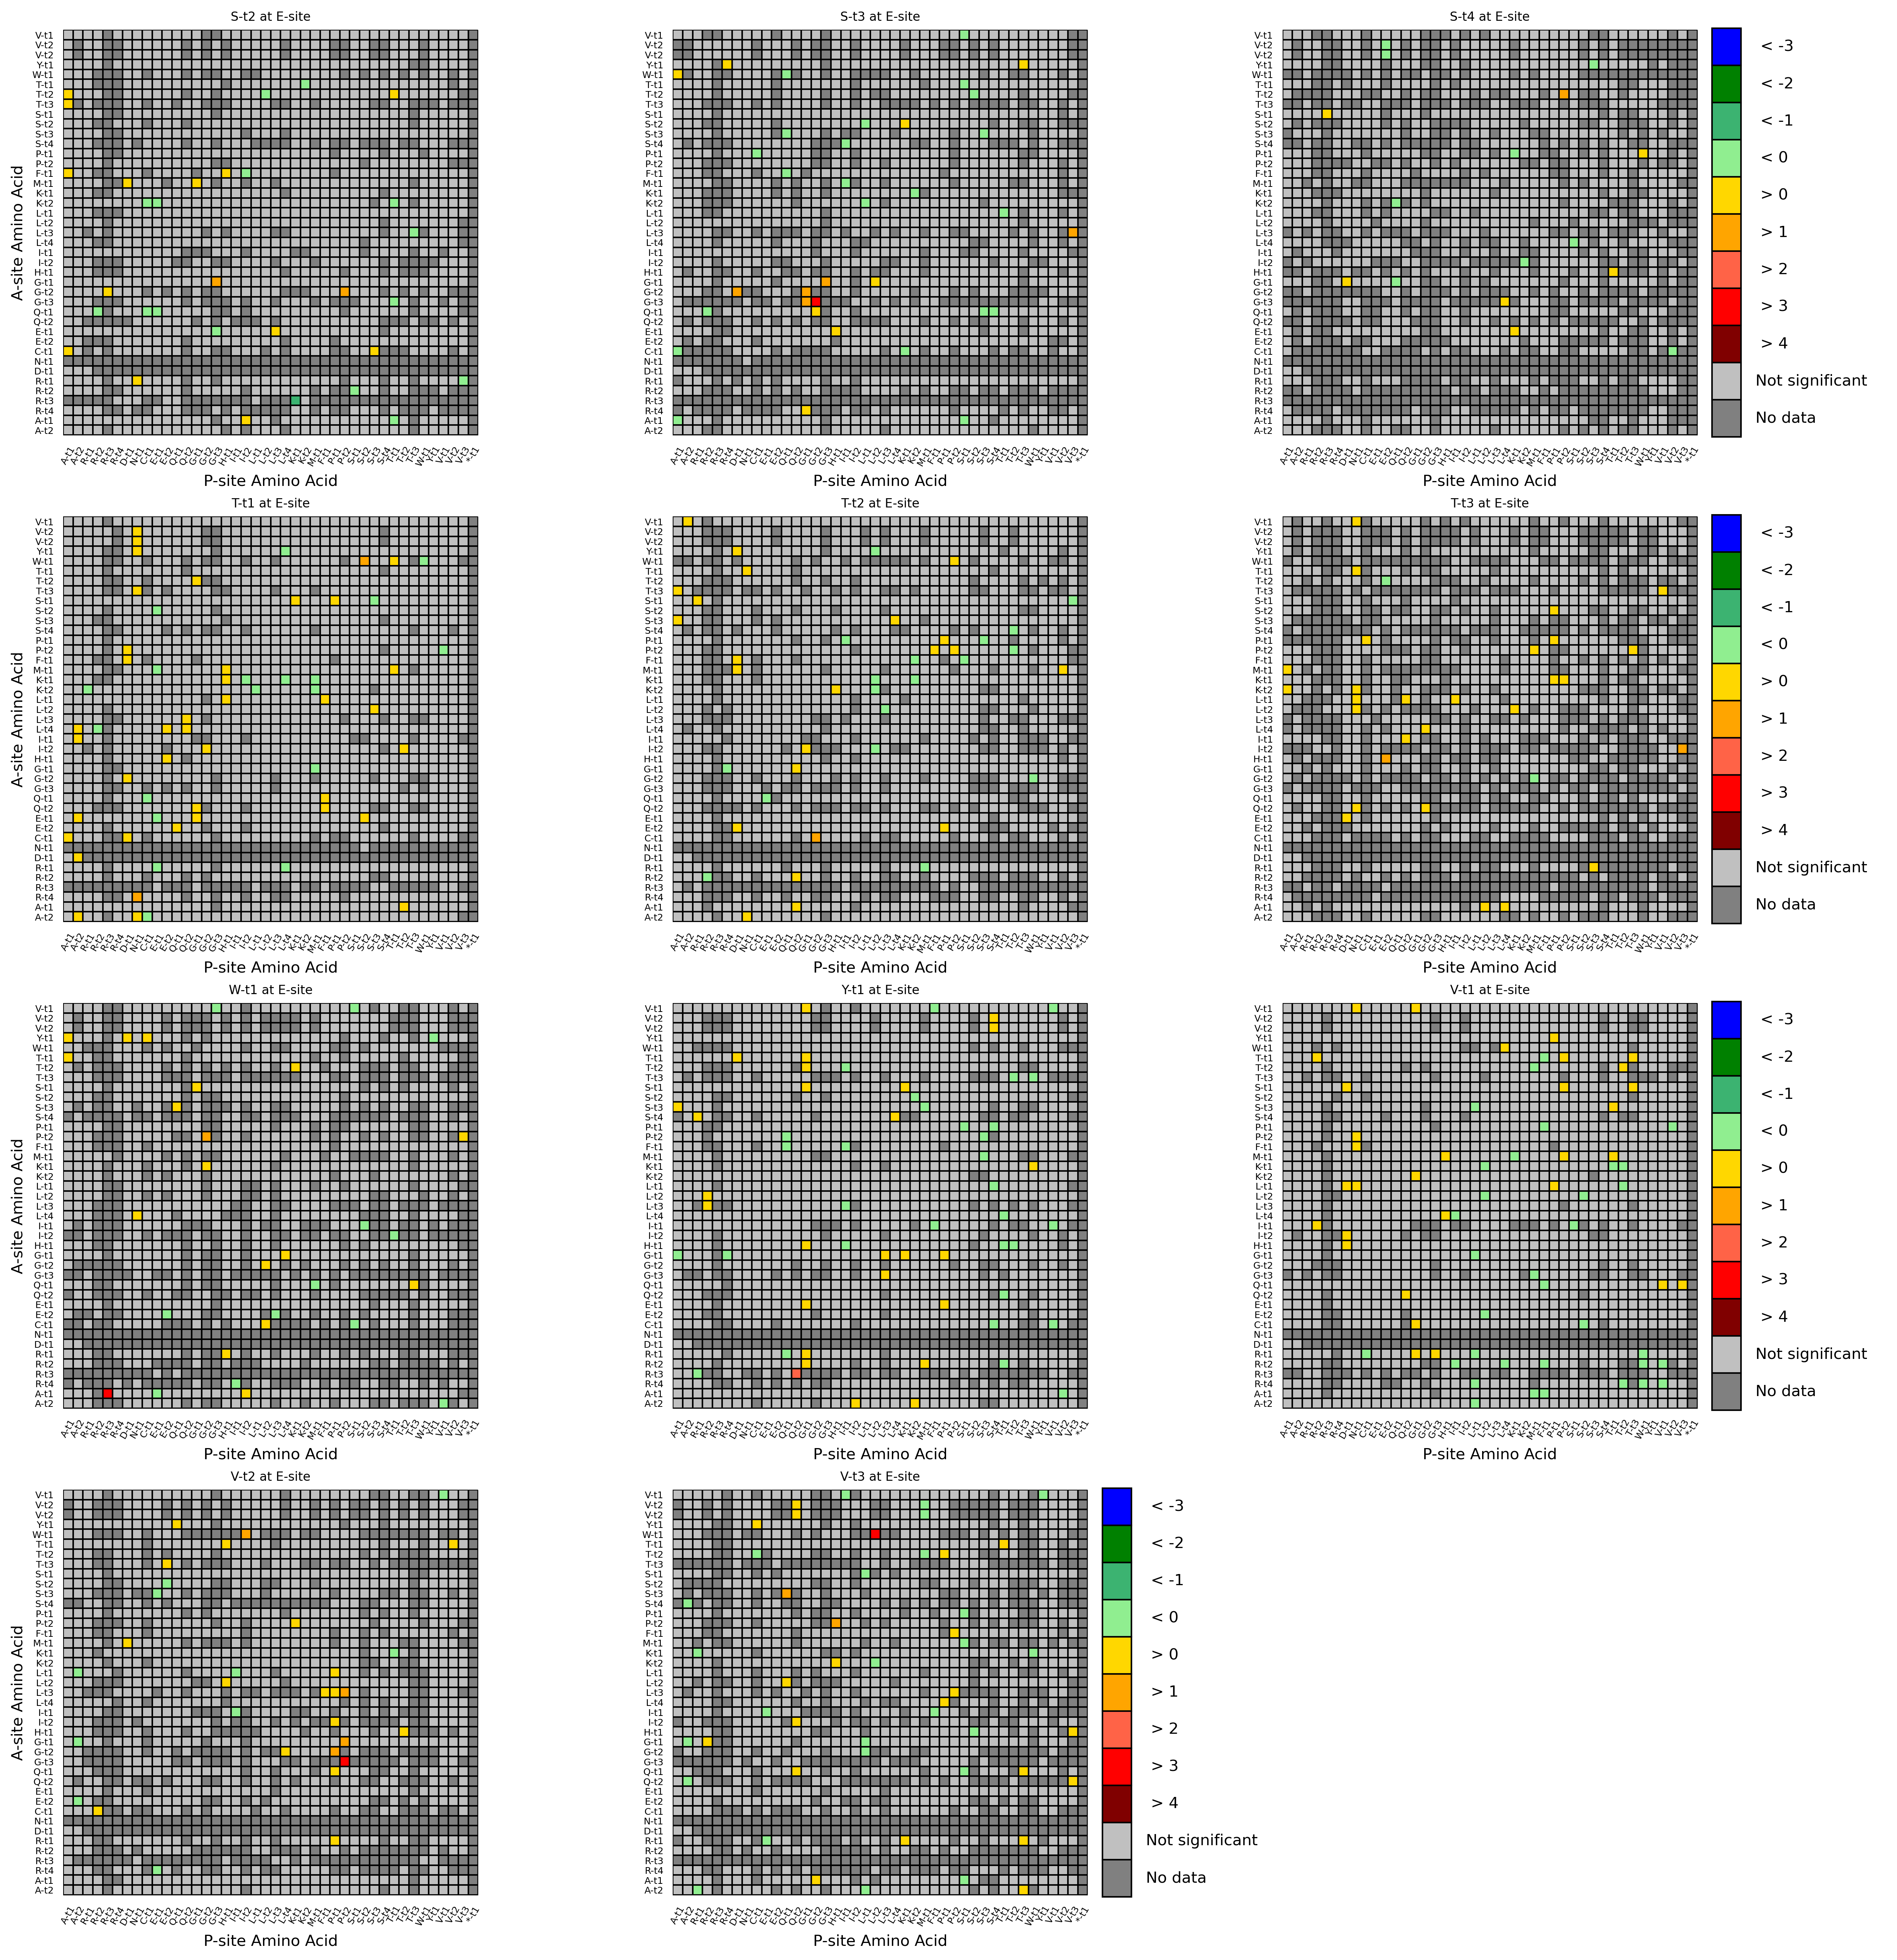

In [18]:
Input_path= path+'A_site_profile_file/robust_amino_acid_matrix/Robust_aminoacid_pairs_Not_controlled_for_any_factors_amino_acid_matrix_0_datasets.tab'
File_path = path+'A_site_profile_file/matrix_file/complete_site_change/'
out_path = path+'A_site_profile_file/matrix_file/'

A_P_E_site_matrix_create(Input_path, out_path, fix_site = 'E-site')

Creation of the directory %s failed


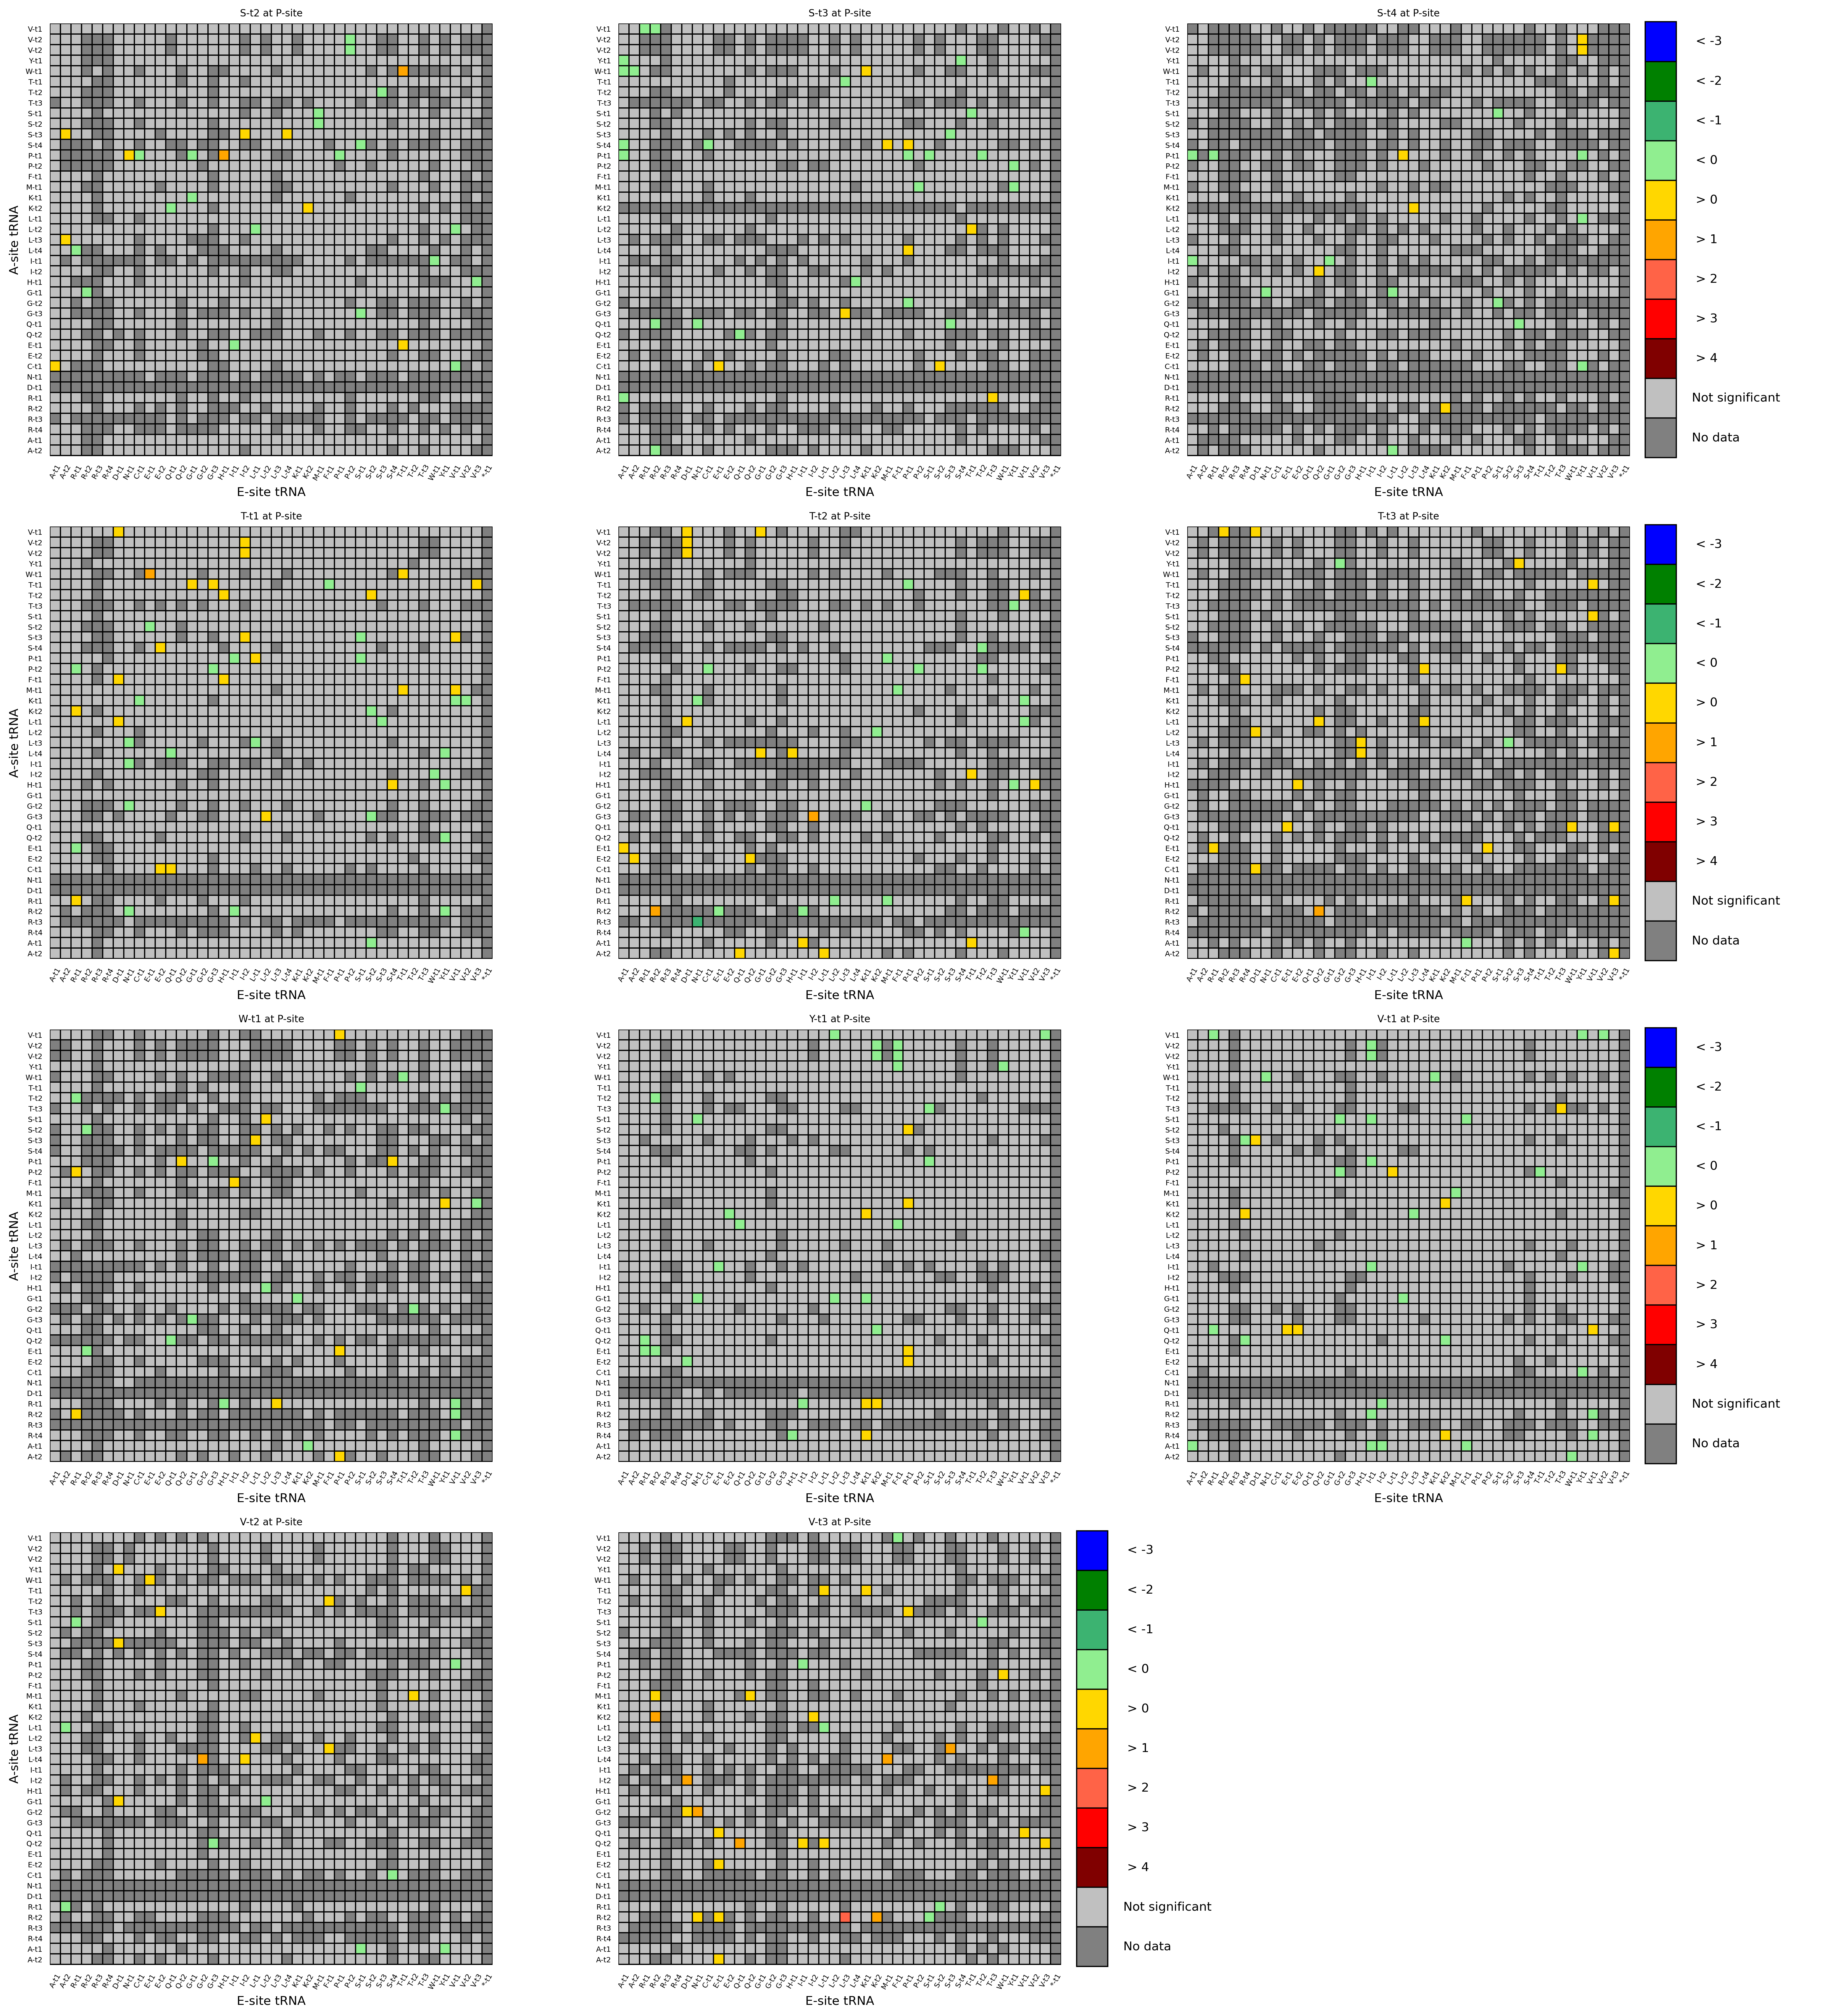

In [76]:
Input_path= path+'A_site_profile_file/robust_amino_acid_matrix/Robust_aminoacid_pairs_Not_controlled_for_any_factors_amino_acid_matrix_0_datasets.tab'
File_path = path+'A_site_profile_file/matrix_file/complete_site_change/'
out_path = path+'A_site_profile_file/matrix_file/'

A_P_E_site_matrix_create(Input_path, out_path, fix_site = 'P-site')

Creation of the directory %s failed


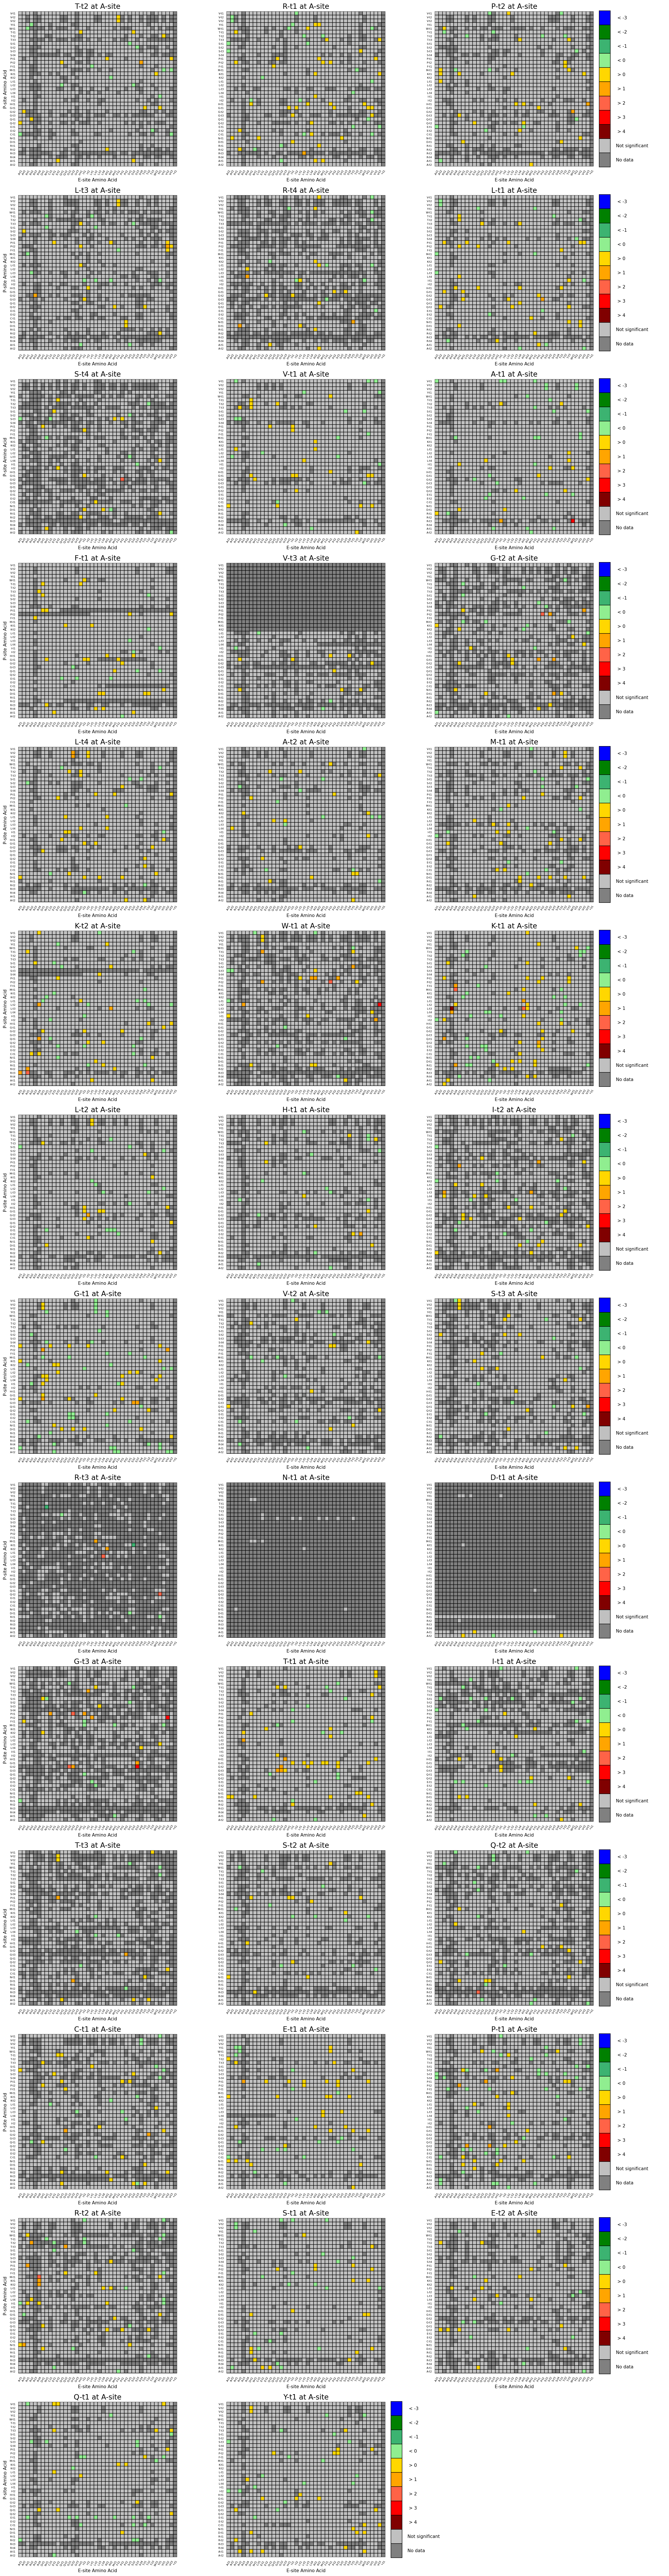

In [51]:
Input_path= path+'A_site_profile_file/robust_amino_acid_matrix/Robust_aminoacid_pairs_Not_controlled_for_any_factors_amino_acid_matrix_0_datasets.tab'
File_path = path+'A_site_profile_file/matrix_file/complete_site_change/'
out_path = path+'A_site_profile_file/matrix_file/'

A_P_E_site_matrix_create(Input_path, out_path, fix_site = 'A-site')

## Combined effect of A, P and Esite with delta1

In [84]:
# color assign for figure
def assign_color(val, new_list_range):
    if math.isnan(val):
        color = 'silver'
    if val == 135875:
        color = 'silver'
    elif val < new_list_range[0]:
        color = 'blue'
    elif val < new_list_range[1]:
        color = 'limegreen'
    elif val < 0:
        color = 'honeydew' # 'palegreen' #'lightgreen'
    elif val > 0:
        color = 'mistyrose'
        if val > new_list_range[3]:
            color = 'red'
        if val > new_list_range[4]:
            color = 'darkred'
    
    return matplotlib.colors.ColorConverter().to_rgb(color)

#matrix figure geneate
def matrix_fig(site_effect, new_list_range, ax = ''):
    xlabel_detail = 'Site'
    ylabel_detail = 'tRNA'    
    
    # control parameters for figure appearance
    axis_label_fontsize = 5
    legend_fontsize = 14
    pannel_label_fontsize = 20
    ticklabel_fontsize = 12
    spine_linewidth = 1.2
    tick_width = 2
    tick_length = 4

    matplotlib.rcParams['figure.dpi']= 600
    PA_label = ['E_site','P_site','A_site']
    AA_label = ['V-t1', 'V-t2', 'V-t2', 'Y-t1', 'W-t1', 'T-t1', 'T-t2', 'T-t3', 'S-t1', 'S-t2', 'S-t3', 'S-t4', 'P-t1', 'P-t2', 'F-t1', 'M-t1', 'K-t1', 'K-t2', 'L-t1', 'L-t2', 'L-t3', 'L-t4', 'I-t1', 'I-t2', 'H-t1', 'G-t1', 'G-t2', 'G-t3', 'Q-t1', 'Q-t2', 'E-t1', 'E-t2', 'C-t1', 'N-t1', 'D-t1', 'R-t1', 'R-t2', 'R-t3', 'R-t4', 'A-t1', 'A-t2']
    data = np.zeros((len(AA_label), len(PA_label), 3))
    
    for i in range(len(AA_label)):
        for j in range(len(PA_label)):
            label = PA_label[j]+AA_label[i]
            for k in range(59):
                data[i,j,:] = assign_color(site_effect[PA_label[j]][AA_label[i]], new_list_range)

    ax.imshow(data, extent=[-0.5, data.shape[1]-0.5, data.shape[0]-0.46, -0.46])#, aspect='auto')
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_xticklabels(PA_label, fontsize=ticklabel_fontsize, fontweight='normal')
    ax.set_yticklabels(AA_label, fontsize=ticklabel_fontsize, fontweight='normal')
    for edge, spine in ax.spines.items():
        spine.set_color('k')
    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="k", linestyle='-', linewidth=spine_linewidth-1)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.set_xlabel(xlabel_detail, fontsize=axis_label_fontsize)
    ax.set_ylabel(ylabel_detail, fontsize=axis_label_fontsize)
    ax.xaxis.set_tick_params(width=tick_width-1, length=tick_length)
    ax.yaxis.set_tick_params(width=tick_width-1, length=tick_length)
    plt.xticks(rotation=45)
    ax.set_anchor('W')
    
    # legend 
    cell_text = [['', '', ' < '+str(round(new_list_range[0], 2))],
                 ['', '', ' < '+str(round(new_list_range[1], 2))],
                 ['', '', ' < 0'],
                 ['', '', ' > 0'],
                 ['', '', ' > '+str(round(new_list_range[3], 2))],
                 ['', '', ' > '+str(round(new_list_range[4], 2))],
                 ['', '', ' == Not_robust']]
    cell_color = [['w', 'blue', 'w'],
                  ['w', 'limegreen', 'w'],
                  ['w', 'honeydew', 'w'],
                  ['w', 'mistyrose', 'w'],
                  ['w', 'red', 'w'],
                  ['w', 'darkred', 'w'],
                 ['w', 'silver', 'w']]


    handle = ax.table(cellText=cell_text, cellColours=cell_color, cellLoc='left',
                      loc='right', colWidths=[0.2, 0.4, 2], edges='closed') #colWidths=[0.05, 0.1, 0.5]  colWidths=[0.05, 0.05, 0.2]
    for i in range(len(cell_text)):
        for j in range(len(cell_text[0])):
            handle[i,j].visible_edges = ''
    for i in range(len(cell_text)):
        handle[i,1].visible_edges = 'BRTL'
    handle.set_fontsize(legend_fontsize)
    handle.scale(0.75, 3)
    #ax.set_title("percentage change")

    return 



def Map_combined_effect_of_A_P_and_E_site(ape_file, out_path):
    read_csv = pd.read_csv(ape_file, sep = "\t")
    #print(read_csv)
    site_effect = {}
    site_effect['A_site'] = {}
    site_effect['P_site'] = {}
    site_effect['E_site'] = {}
    for aa in tRNA_list:
        if '*' == aa:
            continue


        if len(read_csv[(read_csv.Asite_aa == aa) & (read_csv.Cooprative_effect != 'Non_Robust')].Delta1_median.values.tolist()) > 10 :
            site_effect['A_site'][aa]=np.median(read_csv[(read_csv.Asite_aa == aa) & (read_csv.Cooprative_effect != 'Non_Robust')].Delta1_median.values.tolist())
        else:
            site_effect['A_site'][aa]=135875
        if len(read_csv[(read_csv.Psite_aa == aa) & (read_csv.Cooprative_effect != 'Non_Robust')].Delta1_median.values.tolist()) > 10:
            site_effect['P_site'][aa]=np.median(read_csv[(read_csv.Psite_aa == aa) & (read_csv.Cooprative_effect != 'Non_Robust')].Delta1_median.values.tolist())
        else:
            site_effect['P_site'][aa]=135875
        if len(read_csv[(read_csv.Esite_aa == aa) & (read_csv.Cooprative_effect != 'Non_Robust')].Delta1_median.values.tolist()) > 10:
            site_effect['E_site'][aa]=np.median(read_csv[(read_csv.Esite_aa == aa) & (read_csv.Cooprative_effect != 'Non_Robust')].Delta1_median.values.tolist())
        else:
            site_effect['E_site'][aa]=135875


    new_list_range = list_range(site_effect['A_site'],site_effect['P_site'],site_effect['E_site'])
    fig = plt.figure(figsize=(3, 5), dpi=300)
    ax = fig.add_subplot()
    
    matrix_fig(site_effect, new_list_range, ax=ax)
    ax.tick_params(width=0.5, length=2, axis='both', which='major', labelsize=4, pad=2)
    fig.savefig(out_path+'Heatmap_to_show_Combined_effect_of_A_P_E_site_matrix_at_tRNA_lable.png', bbox_inches = 'tight')
    
    return


def list_range(dict1, dict2, dict3):
    new_list = []
    for data in (dict1, dict2, dict3):
        for aa in tRNA_list:
            if '*' in aa:
                continue
            new_list.append(data[aa])
    Output = sorted(new_list, key = lambda x:float(x))
    new_list_range = [-0.25, -0.15, 0, 0.25, 0.50]
    return new_list_range


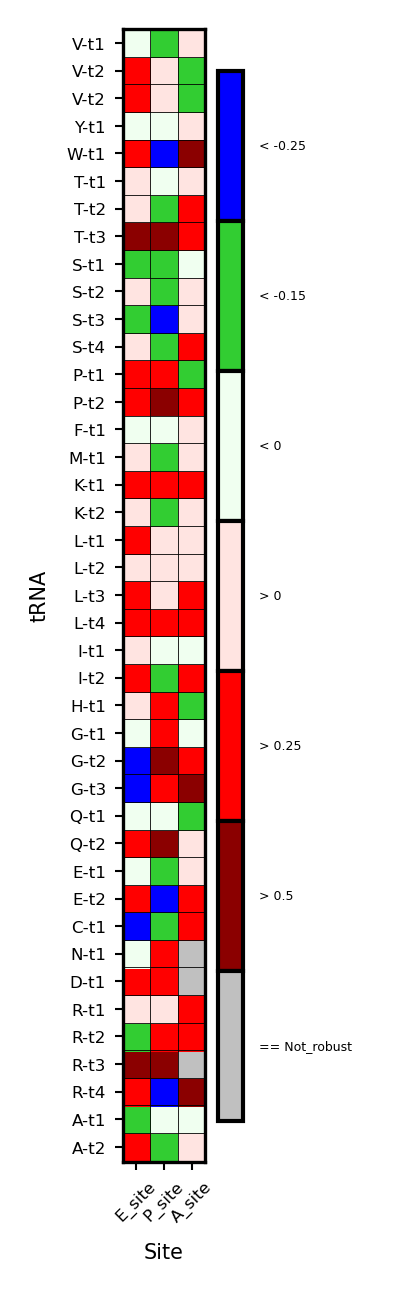

In [85]:
# A, P and E site robust file read
ape_file = path+'A_site_profile_file/robust_amino_acid_matrix/Robust_aminoacid_pairs_Not_controlled_for_any_factors_amino_acid_matrix_0_datasets.tab'
out_path = path+'A_site_profile_file/matrix_file/'
Map_combined_effect_of_A_P_and_E_site(ape_file, out_path)